In [1]:
!pip install -q python-igraph scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.8 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")

# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")



100%|██████████| 9.91M/9.91M [00:00<00:00, 40.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.14MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.90MB/s]


Total number of '1' images in the training set: 6742
Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import igraph as ig

def visualize_k_nearest_neighbors_graph(unique_vectors, k):
    """
    Builds an unweighted graph with python-igraph where each unique vector is a node.
    Each node is connected to its k nearest neighbors (excluding itself).

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, d) containing feature vectors.
        k (int): Number of nearest neighbors for each node.

    Returns:
        g (igraph.Graph): The constructed unweighted graph.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building unweighted k-NN graph for {n} nodes...")

    # Find k nearest neighbors for each node. Note: The first neighbor is the point itself.
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)

    edge_list = []
    for i, neigh in enumerate(indices):
        # Skip the first neighbor (self) and add undirected edges only once.
        for j in neigh[1:]:
            if i < j:
                edge_list.append((i, j))

    # Create an undirected graph.
    g = ig.Graph(n=n, edges=edge_list, directed=False)
    print(f"Unweighted k-NN graph built with {len(edge_list)} edges.")
    return g

g = visualize_k_nearest_neighbors_graph(unique_vectors, 5)


Building unweighted k-NN graph for 6726 nodes...
Unweighted k-NN graph built with 15285 edges.


In [4]:
# prompt: print 5 biggest connected components in g and how many nodes and edges are in each

# Find connected components
clusters = g.clusters()

# Sort clusters by size in descending order and get the 5 largest
largest_clusters = sorted(clusters, key=len, reverse=True)[:5]

# Print information about the 5 largest connected components
for i, cluster in enumerate(largest_clusters):
    subgraph = g.subgraph(cluster)
    print(f"Connected Component {i+1}:")
    print(f"  Number of nodes: {subgraph.vcount()}")
    print(f"  Number of edges: {subgraph.ecount()}")


Connected Component 1:
  Number of nodes: 6478
  Number of edges: 15254
Connected Component 2:
  Number of nodes: 4
  Number of edges: 3
Connected Component 3:
  Number of nodes: 3
  Number of edges: 2
Connected Component 4:
  Number of nodes: 3
  Number of edges: 2
Connected Component 5:
  Number of nodes: 3
  Number of edges: 2


<ipython-input-4-c1d80609f63a>:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  clusters = g.clusters()


Average degree: 4.5450490633363065


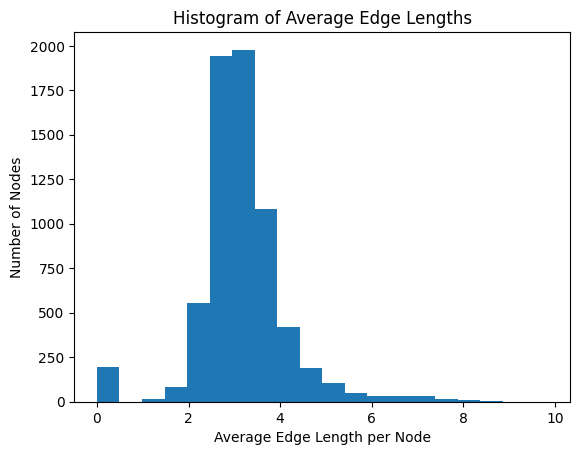

In [5]:
# prompt: Compute average edge length per node.
# Histogram that — you'll see dense vs sparse easily.

import matplotlib.pyplot as plt
import numpy as np
# Compute average edge length per node
avg_degree = g.degree()
print(f"Average degree: {np.mean(avg_degree)}")

# Calculate edge lengths (distances between nodes)
edge_lengths = []
for edge in g.es:
    source_node = edge.source
    target_node = edge.target
    distance = np.linalg.norm(unique_vectors[source_node] - unique_vectors[target_node])
    edge_lengths.append(distance)

# Compute average edge length per node
avg_edge_length_per_node = []
for node_index in range(g.vcount()):
  neighbor_indices = g.neighbors(node_index)
  edge_lengths_for_node = []
  for neighbor in neighbor_indices:
      # Find the edge connecting current node to its neighbor
      edge = g.get_eid(node_index, neighbor)
      edge_lengths_for_node.append(edge_lengths[edge])

  if edge_lengths_for_node:
    avg_edge_length_per_node.append(np.mean(edge_lengths_for_node))
  else:
    avg_edge_length_per_node.append(0)


# Plotting the histogram of average edge lengths
plt.hist(avg_edge_length_per_node, bins=20)  # Adjust bins as needed
plt.xlabel("Average Edge Length per Node")
plt.ylabel("Number of Nodes")
plt.title("Histogram of Average Edge Lengths")
plt.show()


In [6]:
# Find a small simple cycle in graph g by looking for a triangle.
triangles = g.cliques(min=3, max=3)
if triangles:
    cycle = list(triangles[0])  # First triangle (cycle of length 3)
    print("Small simple cycle (triangle):", cycle)
else:
    print("No triangle (small cycle) found in graph g.")

# Assuming 'cycle' is a list of vertex indices from a found cycle (e.g., a triangle)
cycle_vectors = unique_vectors[cycle]  # Get the corresponding vectors
print("Vectors for vertices in the cycle:", cycle_vectors)


Small simple cycle (triangle): [5184, 5185, 5900]
Vectors for vertices in the cycle: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [7]:
import numpy as np
import torch

# Assume cycle_vectors is already defined and contains three vectors.
v1, v2, v3 = cycle_vectors

def get_plane_function(v1, v2, v3):
    """
    Returns a function that computes a point on the plane spanned by v1, v2, v3.

    The returned function takes parameters a and b and computes:
        P(a, b) = v1 + a*(v2 - v1) + b*(v3 - v1)

    To remain within the triangle spanned by v1, v2, and v3, choose a, b >= 0 with a + b <= 1.
    """
    u = v2 - v1
    v = v3 - v1

    def plane_fn(a, b):
        return v1 + a * u + b * v

    return plane_fn

# Create the plane function using the vertices.
plane_fn = get_plane_function(v1, v2, v3)

# Example usage: compute a point on the plane
a, b = 0, 1
P = plane_fn(a, b)
print(torch.all(torch.eq(P, v3)))  # This should output True if v1, v2, v3 are torch tensors.


tensor(True)


In [8]:
import numpy as np

constant_indices = []
constant_values = []

for col in range(unique_vectors.shape[1]):
    vals = unique_vectors[:, col]
    # Instead of np.all(vals == vals[0]), use the array method:
    if (vals == vals[0]).all():
        constant_indices.append(col)
        constant_values.append(vals[0])

print("Constant columns (indices):", constant_indices)
print("Length of indices: ", len(constant_indices))
print("Constant values for these columns:", constant_values)


Constant columns (indices): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 107, 108, 109, 110, 111, 112, 113, 115, 116, 137, 138, 139, 140, 141, 142, 143, 165, 166, 167, 168, 169, 170, 172, 193, 194, 195, 196, 197, 198, 199, 221, 222, 223, 224, 225, 226, 227, 249, 250, 251, 252, 253, 254, 255, 277, 278, 279, 280, 282, 283, 304, 305, 306, 307, 308, 309, 310, 311, 313, 332, 335, 336, 337, 338, 341, 360, 361, 362, 363, 364, 365, 366, 367, 369, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 397, 398, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 470, 471, 473, 475, 476, 477, 478, 479, 480, 503, 504, 505, 506, 507, 508, 532, 533, 534, 535, 536, 559, 560, 561, 562,

In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import igraph as ig

def visualize_k_nearest_neighbors_graph(unique_vectors, k, distance_threshold):
    """
    Builds an unweighted graph with python-igraph where each unique vector is a node.
    Each node is connected to its k nearest neighbors (excluding itself), but only if
    the Euclidean distance is less than the specified distance_threshold.

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, d) containing feature vectors.
        k (int): Number of nearest neighbors for each node.
        distance_threshold (float): Maximum distance for which an edge is added.

    Returns:
        g (igraph.Graph): The constructed unweighted graph.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building unweighted k-NN graph for {n} nodes with distance threshold {distance_threshold}...")

    # Find k nearest neighbors for each node. (The first neighbor is the point itself.)
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)

    edge_list = []
    # Loop over each node and its k nearest neighbors (skipping the first one, which is the node itself)
    for i in range(n):
        for j, d in zip(indices[i][1:], distances[i][1:]):
            if d < distance_threshold and i < j:
                edge_list.append((i, j))

    # Create an undirected graph using python-igraph.
    g = ig.Graph(n=n, edges=edge_list, directed=False)
    print(f"Unweighted k-NN graph built with {len(edge_list)} edges.")
    return g

# Example usage:
# unique_vectors should be defined beforehand (as a numpy array or torch Tensor).
# Set k and the distance threshold as needed.
g = visualize_k_nearest_neighbors_graph(unique_vectors, k=5, distance_threshold=6)


Building unweighted k-NN graph for 6726 nodes with distance threshold 6...
Unweighted k-NN graph built with 15046 edges.


In [10]:
# prompt: print 5 biggest connected components in g and how many nodes and edges are in each

# Find connected components
clusters = g.clusters()

# Sort clusters by size in descending order and get the 5 largest
largest_clusters = sorted(clusters, key=len, reverse=True)[:5]

# Print information about the 5 largest connected components
for i, cluster in enumerate(largest_clusters):
    subgraph = g.subgraph(cluster)
    print(f"Connected Component {i+1}:")
    print(f"  Number of nodes: {subgraph.vcount()}")
    print(f"  Number of edges: {subgraph.ecount()}")


Connected Component 1:
  Number of nodes: 6362
  Number of edges: 14991
Connected Component 2:
  Number of nodes: 10
  Number of edges: 12
Connected Component 3:
  Number of nodes: 4
  Number of edges: 3
Connected Component 4:
  Number of nodes: 4
  Number of edges: 3
Connected Component 5:
  Number of nodes: 4
  Number of edges: 3


<ipython-input-10-c1d80609f63a>:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  clusters = g.clusters()


In [11]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import igraph as ig

def mutual_knn_graph(unique_vectors, k, distance_threshold):
    """
    Builds an undirected k-NN graph where an edge between nodes i and j is added only if:
      - j is among the k nearest neighbors (excluding itself) of i,
      - i is among the k nearest neighbors (excluding itself) of j,
      - and the Euclidean distance between i and j is less than the specified distance_threshold.

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, d).
        k (int): Number of nearest neighbors to consider.
        distance_threshold (float): Maximum distance to allow an edge.

    Returns:
        g (igraph.Graph): The constructed undirected graph.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building mutual k-NN graph for {n} nodes (k={k}, distance_threshold={distance_threshold})...")

    # Compute k+1 nearest neighbors for each node (the first neighbor is the point itself).
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)

    edge_list = []
    for i in range(n):
        # Iterate over node i's k nearest neighbors (skip the first, which is i itself)
        for j, d in zip(indices[i][1:], distances[i][1:]):
            if d < distance_threshold:
                # Check if node i is also among node j's k nearest neighbors (excluding itself)
                if i in indices[j][1:]:
                    # To avoid duplicate edges, add only if i < j.
                    if i < j:
                        edge_list.append((i, j))

    # Create an undirected graph using the computed edge list.
    g = ig.Graph(n=n, edges=edge_list, directed=False)
    print(f"Mutual k-NN graph built with {len(edge_list)} edges.")
    return g

# Example usage:
g = mutual_knn_graph(unique_vectors, k=5, distance_threshold=6)


Building mutual k-NN graph for 6726 nodes (k=5, distance_threshold=6)...
Mutual k-NN graph built with 8023 edges.


In [81]:
# prompt: print 5 biggest connected components in g and how many nodes and edges are in each

# Find connected components
clusters = g.clusters()

# Sort clusters by size in descending order and get the 5 largest
largest_clusters = sorted(clusters, key=len, reverse=True)[:5]
g_largest = g.subgraph(largest_clusters[0])
largest_component = max(clusters, key=len)

# Print information about the 5 largest connected components
for i, cluster in enumerate(largest_clusters):
    subgraph = g.subgraph(cluster)
    print(f"Connected Component {i+1}:")
    print(f"  Number of nodes: {subgraph.vcount()}")
    print(f"  Number of edges: {subgraph.ecount()}")


Connected Component 1:
  Number of nodes: 5049
  Number of edges: 7540
Connected Component 2:
  Number of nodes: 36
  Number of edges: 40
Connected Component 3:
  Number of nodes: 33
  Number of edges: 46
Connected Component 4:
  Number of nodes: 13
  Number of edges: 18
Connected Component 5:
  Number of nodes: 12
  Number of edges: 11


<ipython-input-81-70ef2516e6ed>:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  clusters = g.clusters()


In [25]:
communities = g_largest.community_edge_betweenness()

In [27]:
communities = communities.as_clustering()

In [63]:
mod = communities.modularity
print("Modularity:", mod)

for i, community in enumerate(communities):
    print(f"Community {i}: Number of nodes: {len(community)}")


Modularity: 0.9149297908941876
Community 0: Number of nodes: 183
Community 1: Number of nodes: 157
Community 2: Number of nodes: 177
Community 3: Number of nodes: 47
Community 4: Number of nodes: 239
Community 5: Number of nodes: 21
Community 6: Number of nodes: 46
Community 7: Number of nodes: 198
Community 8: Number of nodes: 149
Community 9: Number of nodes: 47
Community 10: Number of nodes: 85
Community 11: Number of nodes: 142
Community 12: Number of nodes: 30
Community 13: Number of nodes: 187
Community 14: Number of nodes: 154
Community 15: Number of nodes: 151
Community 16: Number of nodes: 54
Community 17: Number of nodes: 82
Community 18: Number of nodes: 138
Community 19: Number of nodes: 175
Community 20: Number of nodes: 67
Community 21: Number of nodes: 189
Community 22: Number of nodes: 139
Community 23: Number of nodes: 62
Community 24: Number of nodes: 54
Community 25: Number of nodes: 35
Community 26: Number of nodes: 151
Community 27: Number of nodes: 38
Community 28

In [36]:
num_communities = len(communities)
palette1 = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    g_largest.vs[community]["color"] = i
    community_edges = g_largest.es.select(_within=community)
    community_edges["color"] = i

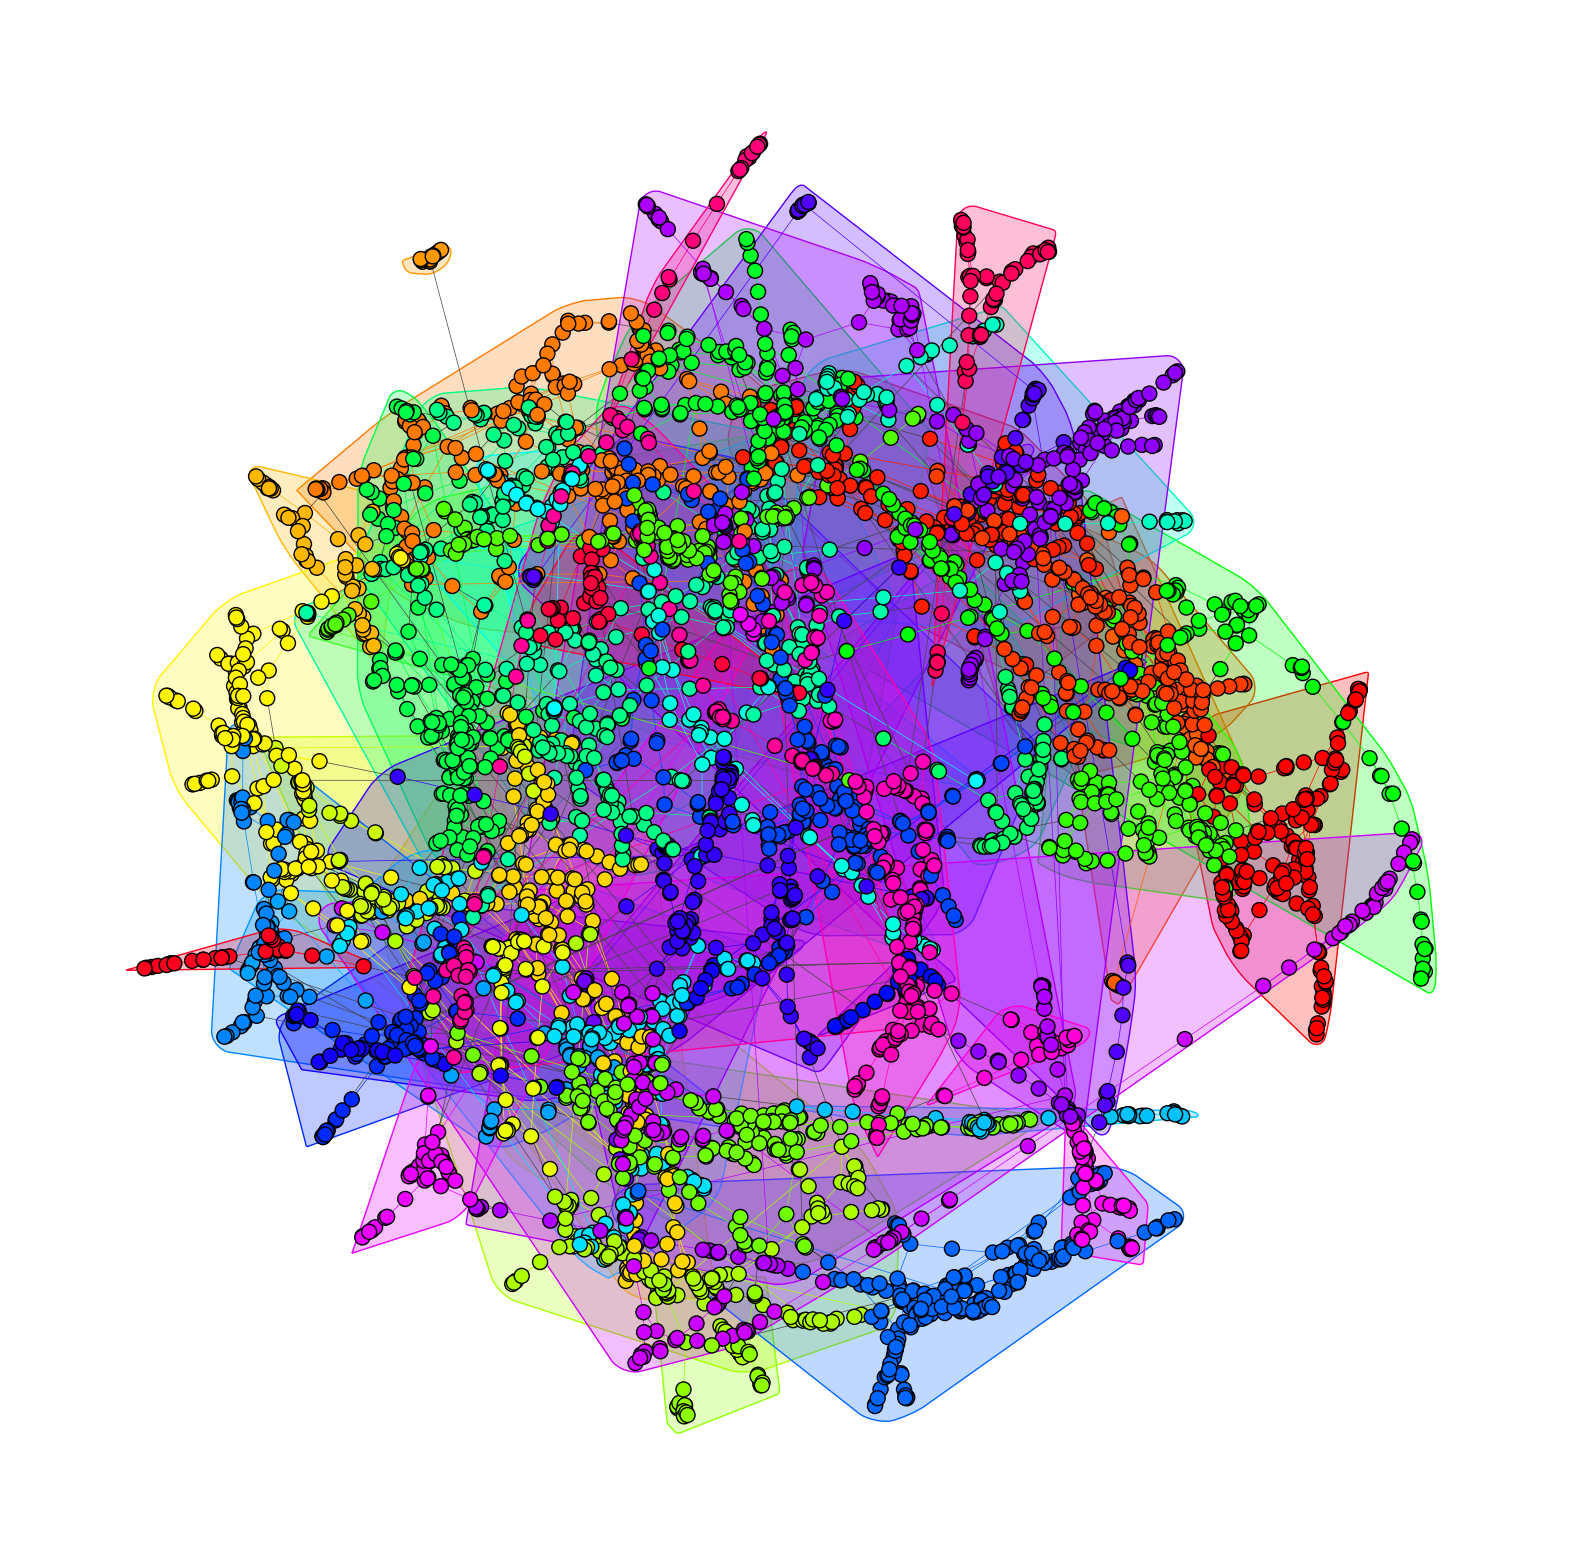

In [38]:
fig1, ax1 = plt.subplots()
ig.plot(
    communities,
    target=ax1,
    mark_groups=True,
    palette=palette1,
    vertex_size=15,
    edge_width=0.5,
)
fig1.set_size_inches(20, 20)

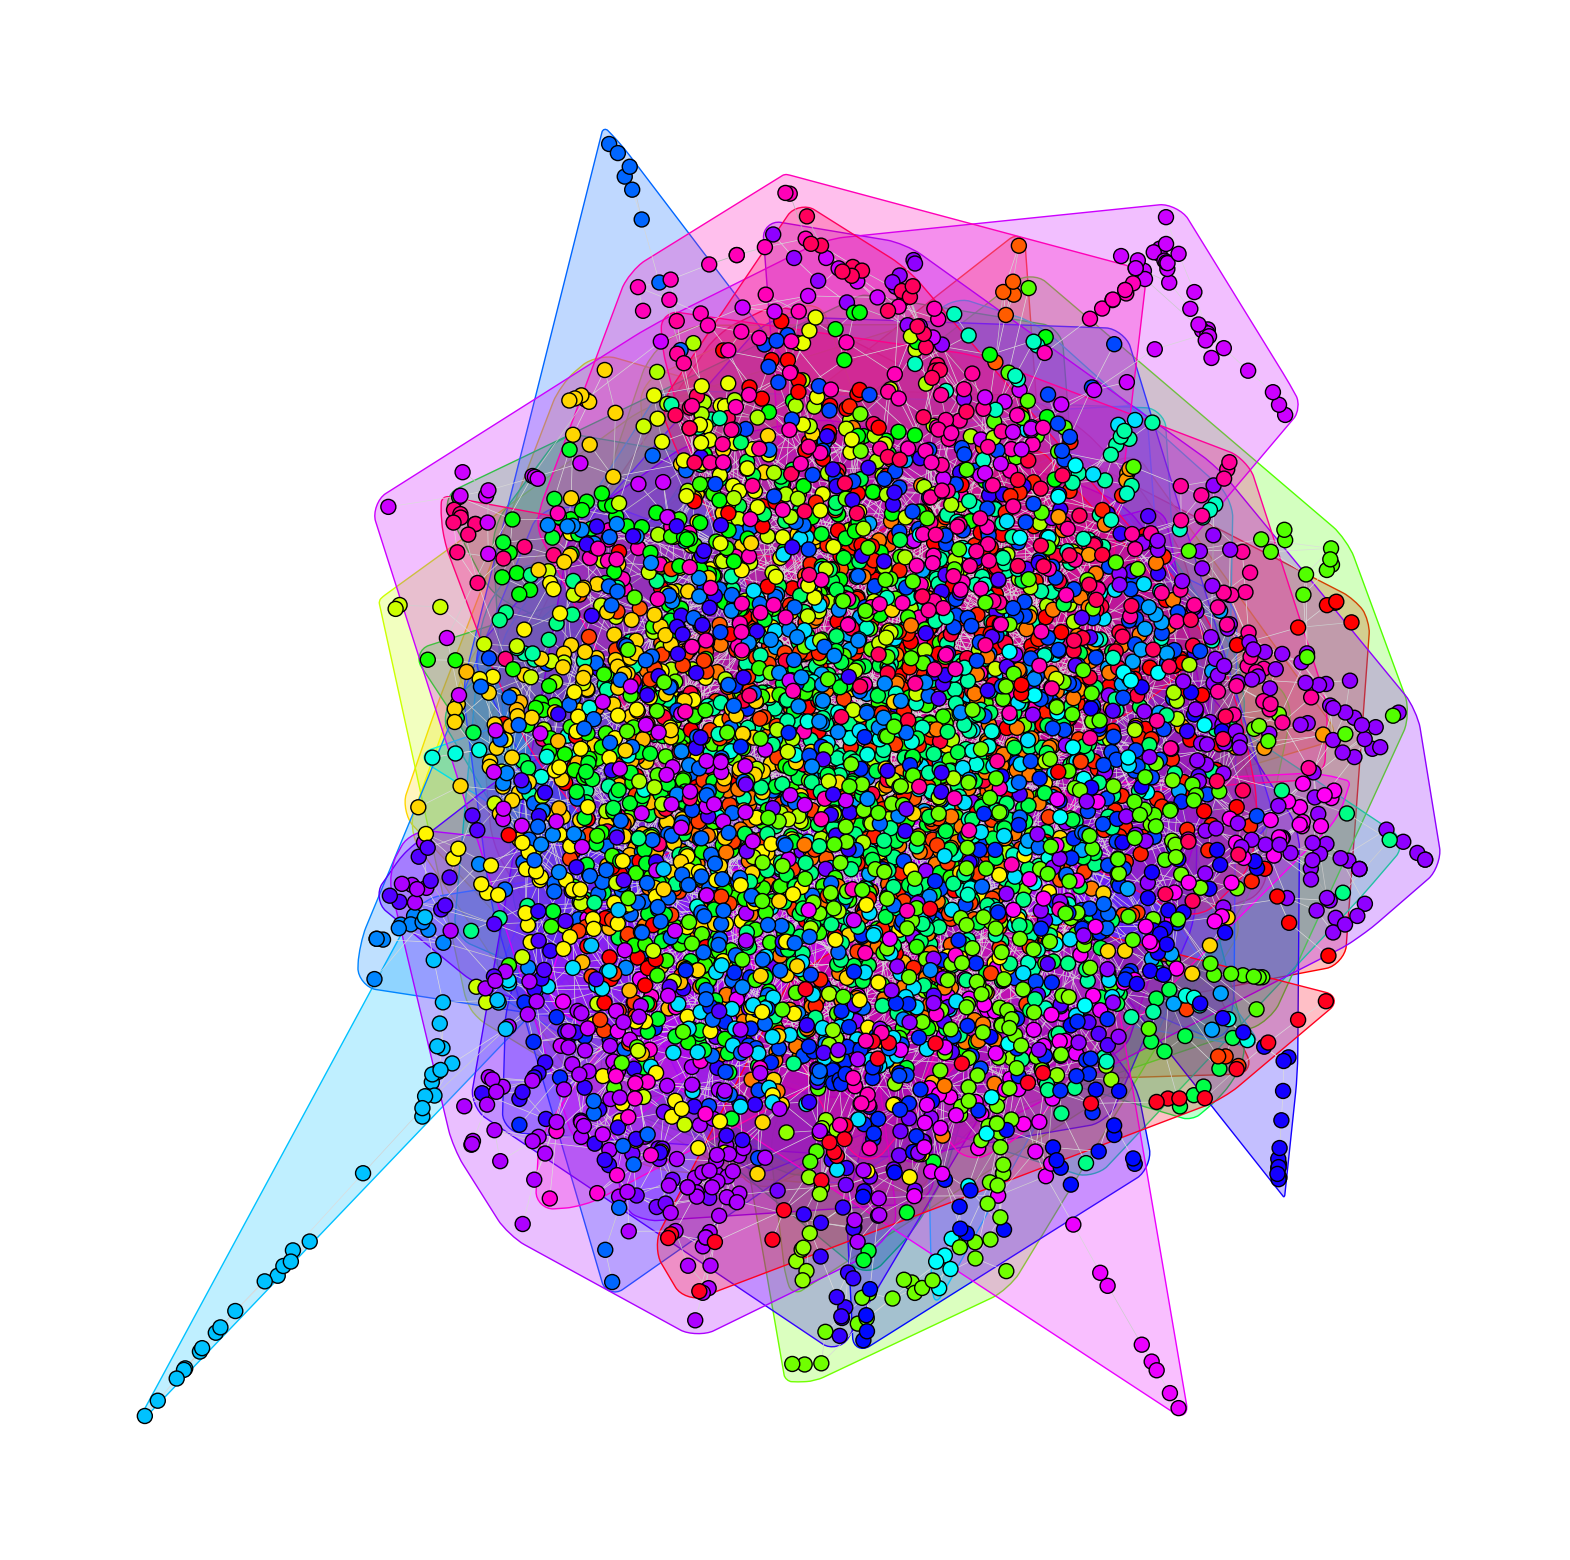

In [52]:
layout = g_largest.layout_fruchterman_reingold(weights=None, niter=1000)

# Plot the graph using the chosen layout.
fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(
    communities,
    target=ax,
    layout=layout,
    palette=palette1,
    vertex_size=15,
    edge_width=0.5,
    mark_groups=True  # This will draw a convex hull around nodes in the same community.
)
plt.show()

In [39]:
layout = g_largest.layout_kamada_kawai()
g_largest.vs["x"], g_largest.vs["y"] = list(zip(*layout))
g_largest.vs["size"] = 15
g_largest.es["size"] = 15

In [40]:
cluster_graph = communities.cluster_graph(
    combine_vertices={
        "x": "mean",
        "y": "mean",
        "color": "first",
        "size": "sum",
    },
    combine_edges={
        "size": "sum",
    },
)

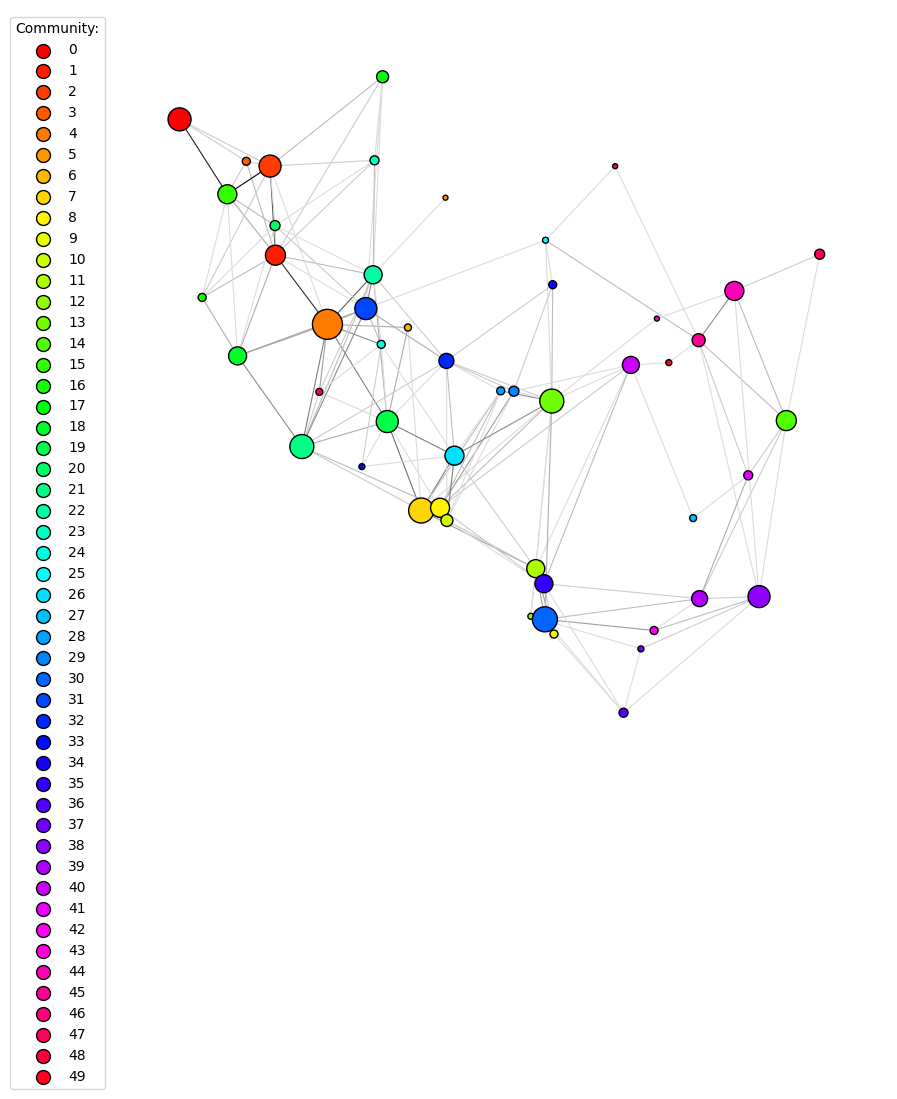

In [55]:
# Rescale the cluster sizes to a manageable range (e.g., min=5, max=30).
# This prevents a single cluster from dominating the plot due to a huge summed size.
cluster_sizes = cluster_graph.vs["size"]
scaled_sizes = ig.rescale(cluster_sizes, (5,30), clamp=True)
cluster_graph.vs["scaled_size"] = scaled_sizes

# Prepare edge coloring for the cluster graph.
palette2 = ig.GradientPalette("gainsboro", "black")
edge_sizes = cluster_graph.es["size"]
edge_color_values = ig.rescale(edge_sizes, (0, 255), clamp=True)
cluster_graph.es["color"] = [palette2.get(int(val)) for val in edge_color_values]

# Plot the cluster graph.
fig2, ax2 = plt.subplots()
ig.plot(
    cluster_graph,
    target=ax2,
    palette=palette1,
    vertex_size=cluster_graph.vs["scaled_size"],
    edge_color=cluster_graph.es["color"],
    edge_width=0.8,
)

# Add a legend for the communities.
legend_handles = []
for i in range(num_communities):
    handle = ax2.scatter(
        [], [],
        s=100,
        facecolor=palette1.get(i),
        edgecolor="k",
        label=str(i),
    )
    legend_handles.append(handle)

ax2.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax2.transAxes,
)

fig2.set_size_inches(10, 10)
plt.show()

In [89]:
# Extract neighbor communities from the cluster graph.
community_neighbors = {}
for v in range(cluster_graph.vcount()):
    # The neighbors() method returns the list of vertex (community) IDs adjacent to v.
    neighbor_ids = cluster_graph.neighbors(v)
    community_neighbors[v] = sorted(neighbor_ids)
    print(f"Community {v} neighbors: {community_neighbors[v]}")


Community 0 neighbors: [2, 3, 15]
Community 1 neighbors: [2, 3, 4, 15, 16, 17, 18, 20, 22, 23, 31]
Community 2 neighbors: [0, 1, 3, 4, 15, 16, 17, 20, 23]
Community 3 neighbors: [0, 1, 2, 15]
Community 4 neighbors: [1, 2, 6, 18, 19, 21, 22, 24, 31, 48]
Community 5 neighbors: [22]
Community 6 neighbors: [4, 7, 19]
Community 7 neighbors: [6, 8, 10, 11, 13, 19, 21, 26, 28]
Community 8 neighbors: [7, 10, 13, 21, 28, 29, 35, 40]
Community 9 neighbors: [11, 35, 36]
Community 10 neighbors: [7, 8, 11, 19, 26, 28, 29, 32, 35]
Community 11 neighbors: [7, 9, 10, 12, 13, 26, 30, 35, 40]
Community 12 neighbors: [11, 13, 30, 37]
Community 13 neighbors: [7, 8, 11, 12, 25, 26, 28, 29, 30, 32, 34, 40, 43]
Community 14 neighbors: [38, 39, 41, 44, 45, 47]
Community 15 neighbors: [0, 1, 2, 3, 16, 18, 20]
Community 16 neighbors: [1, 2, 15, 18, 20]
Community 17 neighbors: [1, 2, 22, 23, 31]
Community 18 neighbors: [1, 4, 15, 16, 20, 21, 31]
Community 19 neighbors: [4, 6, 7, 10, 21, 22, 24, 26, 32, 33, 48]
C

In [ ]:
import numpy as np
import torch

# Iterate over every community.
for i, community in enumerate(communities):
    # Get the list of neighboring communities for community i.
    neighbor_ids = community_neighbors.get(i, [])
    for nb in neighbor_ids:
        connecting_pairs = []  # will hold tuples: (node_i, node_nb, distance)
        for node_i in community:
            for node_nb in communities[nb]:
                if g_largest.are_connected(node_i, node_nb):
                    # Map from g_largest vertex to global index in unique_vectors.
                    global_idx_i = largest_component[node_i]
                    global_idx_nb = largest_component[node_nb]

                    # Retrieve the original 784-dimensional vectors.
                    vec_i = unique_vectors[global_idx_i]
                    vec_nb = unique_vectors[global_idx_nb]

                    # Compute the Euclidean distance.
                    # Assuming unique_vectors is a torch.Tensor; if using numpy, replace with np.linalg.norm().
                    distance = torch.norm(vec_i - vec_nb).item()

                    connecting_pairs.append((node_i, node_nb, distance))
        if connecting_pairs:
            print(f"Nodes connecting Community {i} and Community {nb}:")
            for node_i, node_nb, distance in connecting_pairs:
                print(f"  Node {node_i} <-> Node {node_nb}, distance: {distance:.4f}")
            print("-" * 40)


<ipython-input-96-134f88249669>:12: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g_largest.are_connected(node_i, node_nb):


Nodes connecting Community 0 and Community 2:
  Node 1745 <-> Node 86, distance: 3.8730
  Node 2224 <-> Node 2056, distance: 4.0000
----------------------------------------
Nodes connecting Community 0 and Community 3:
  Node 68 <-> Node 72, distance: 4.0000
  Node 80 <-> Node 165, distance: 3.4641
----------------------------------------
Nodes connecting Community 0 and Community 15:
  Node 100 <-> Node 1871, distance: 3.8730
  Node 101 <-> Node 109, distance: 3.3166
  Node 112 <-> Node 109, distance: 2.8284
  Node 155 <-> Node 159, distance: 3.4641
  Node 1754 <-> Node 1849, distance: 3.3166
  Node 1764 <-> Node 1779, distance: 3.6056
  Node 1771 <-> Node 1908, distance: 3.0000
  Node 1910 <-> Node 1931, distance: 3.4641
  Node 1915 <-> Node 2180, distance: 3.8730
  Node 1923 <-> Node 1908, distance: 3.0000
  Node 1934 <-> Node 1931, distance: 3.6056
  Node 2054 <-> Node 2171, distance: 3.7417
  Node 2212 <-> Node 2208, distance: 3.4641
----------------------------------------
Nodes 

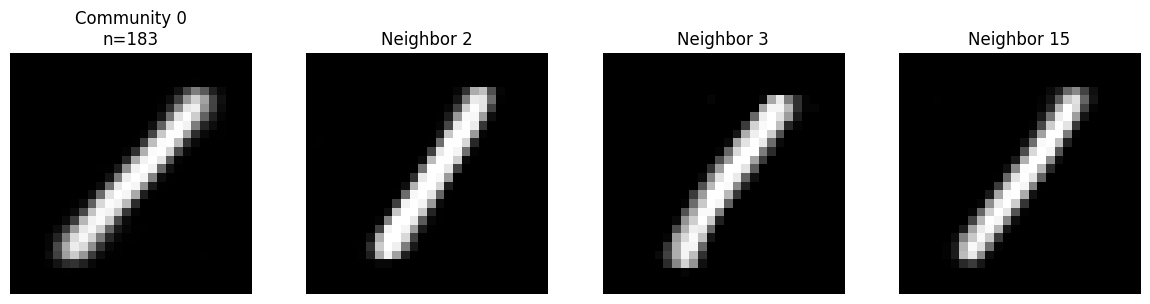

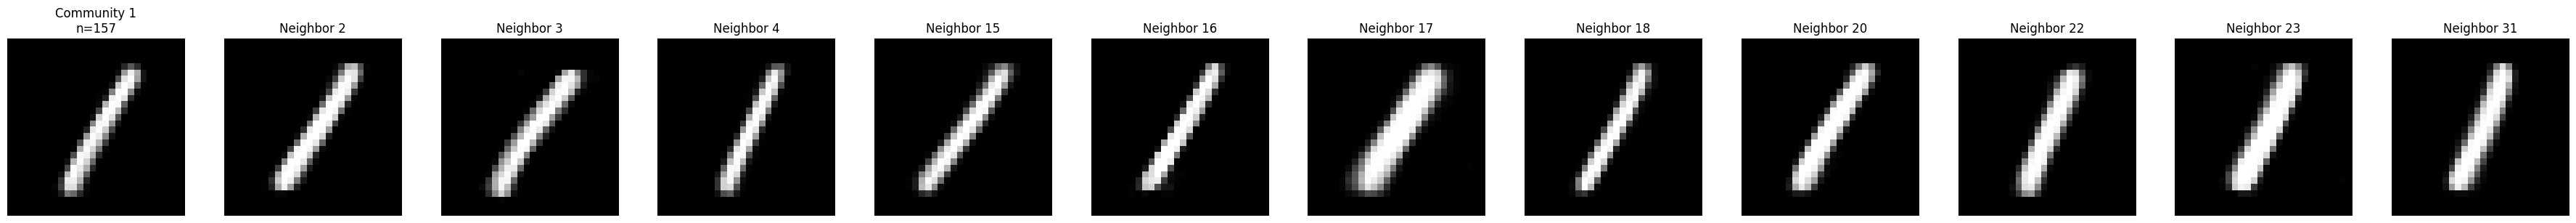

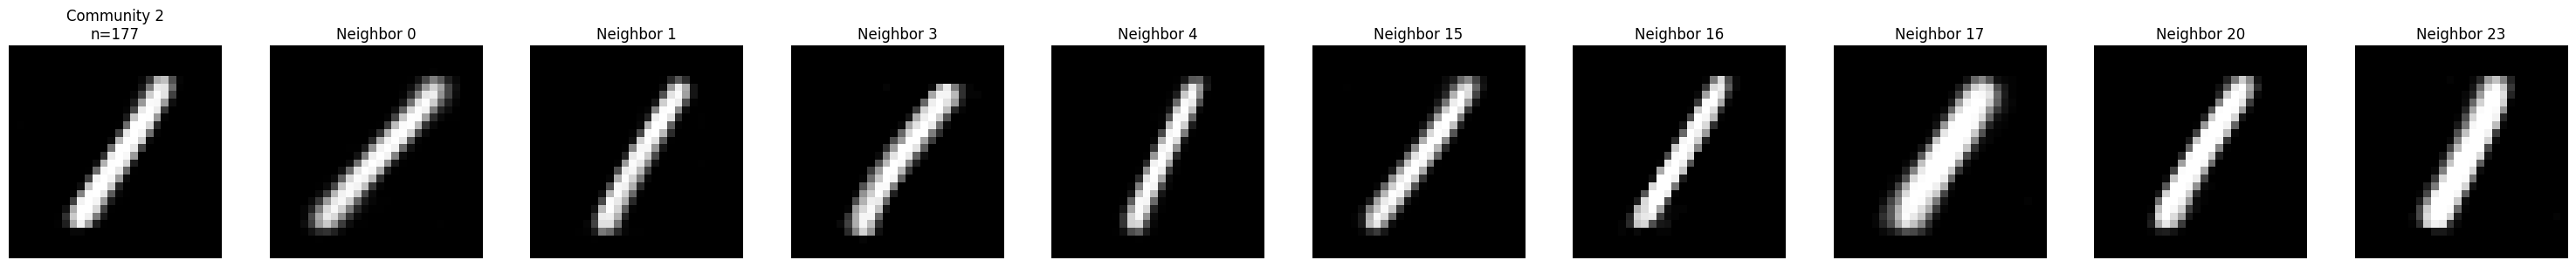

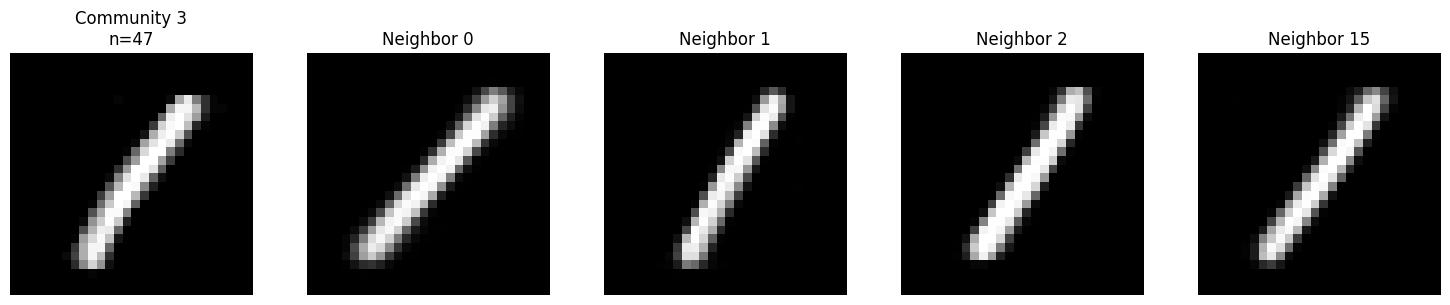

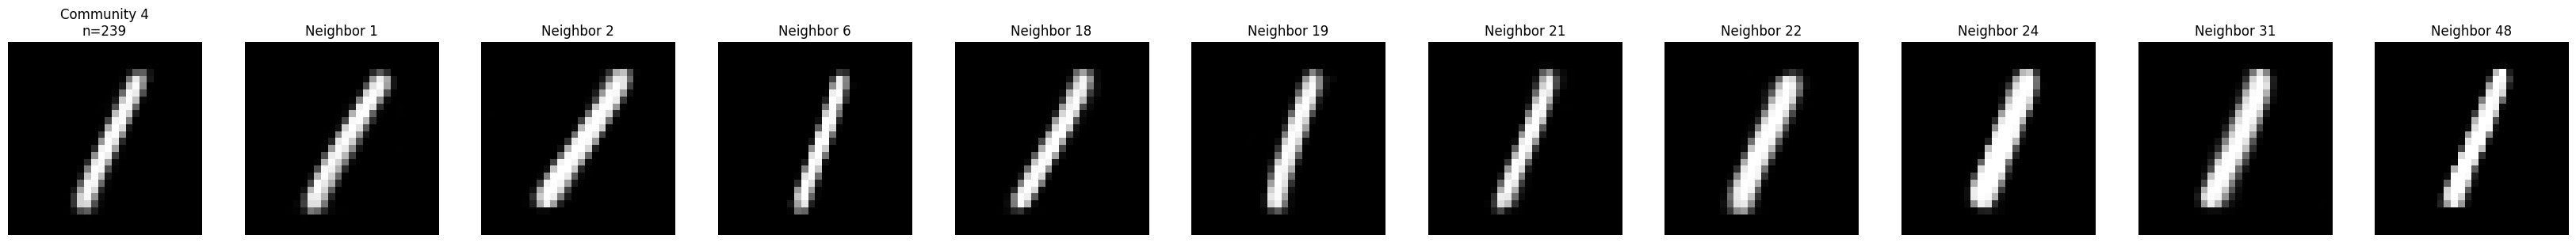

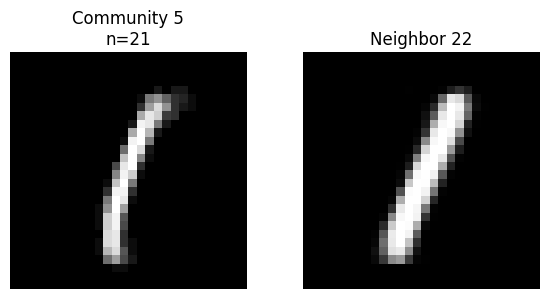

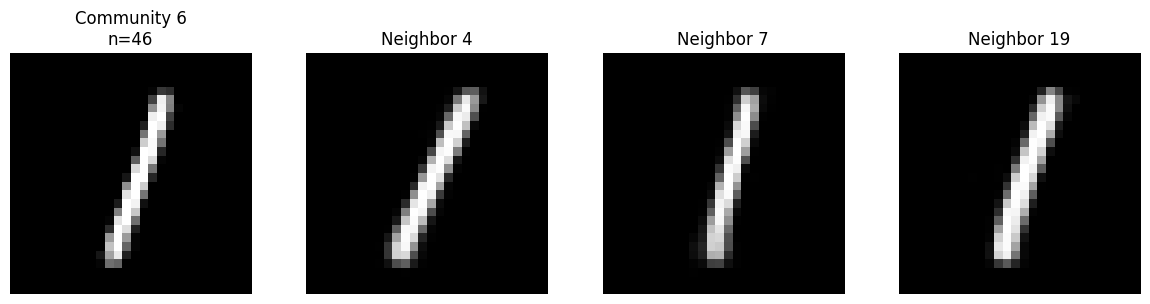

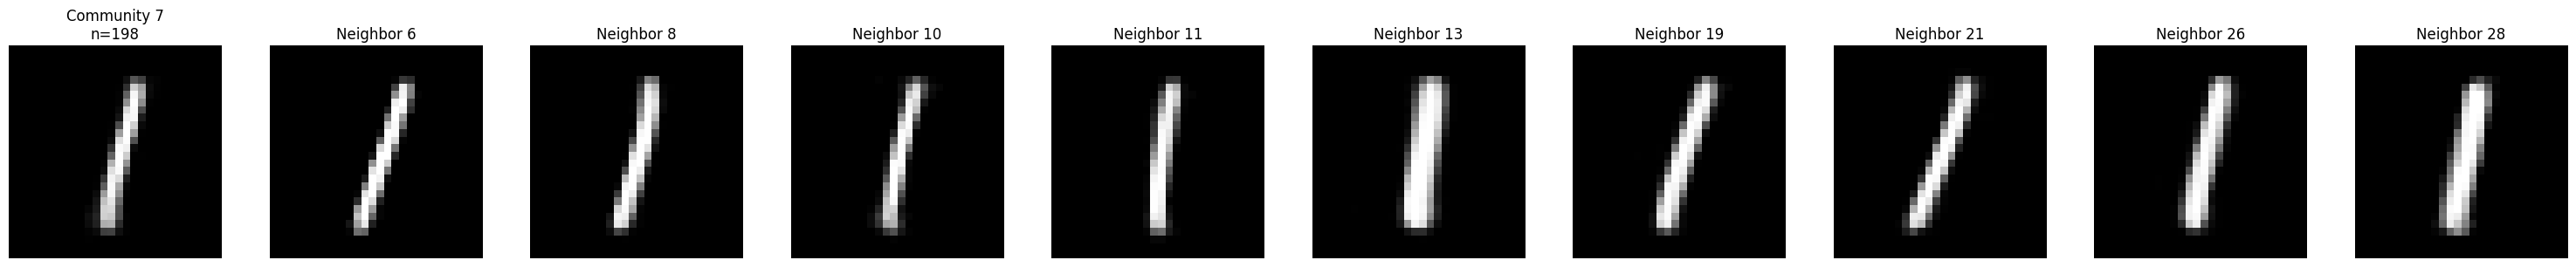

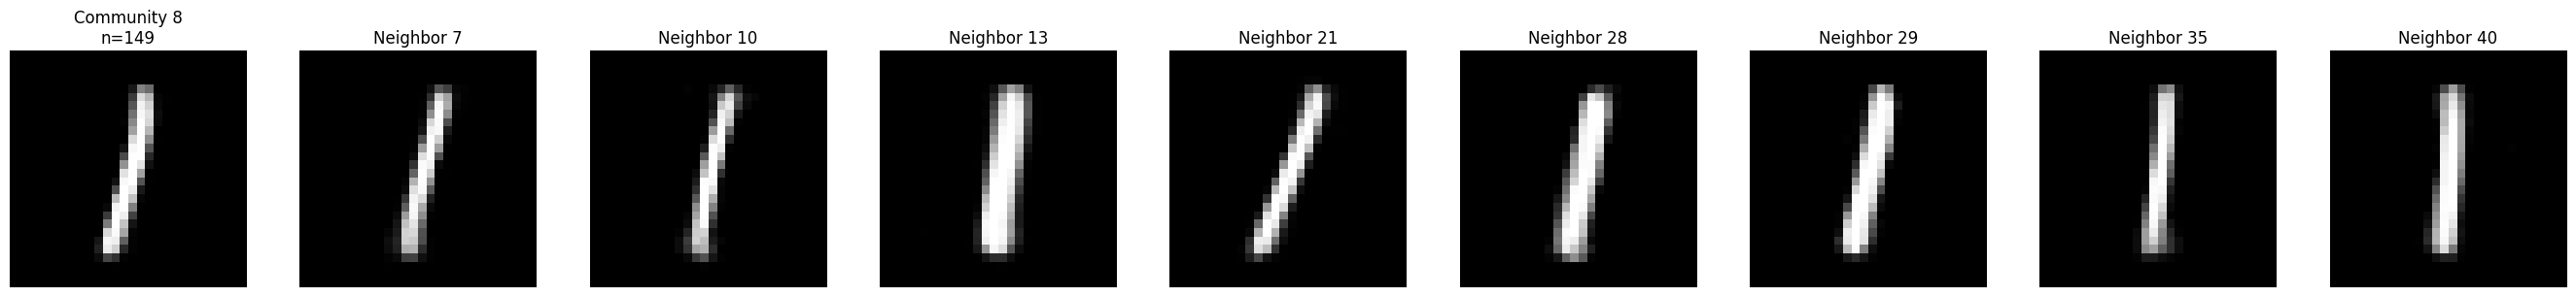

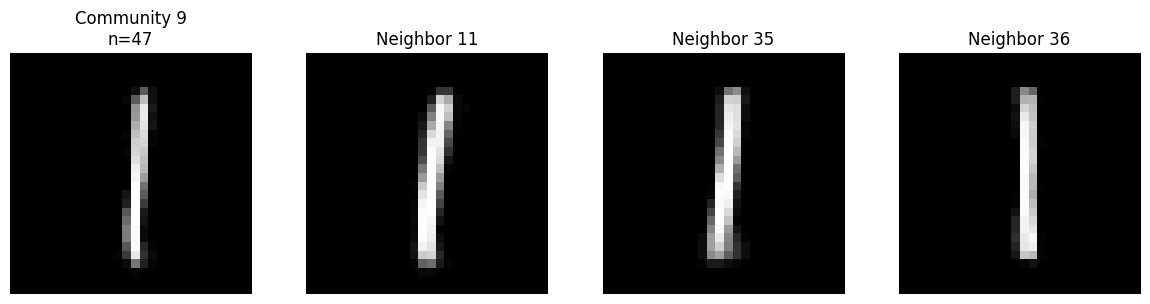

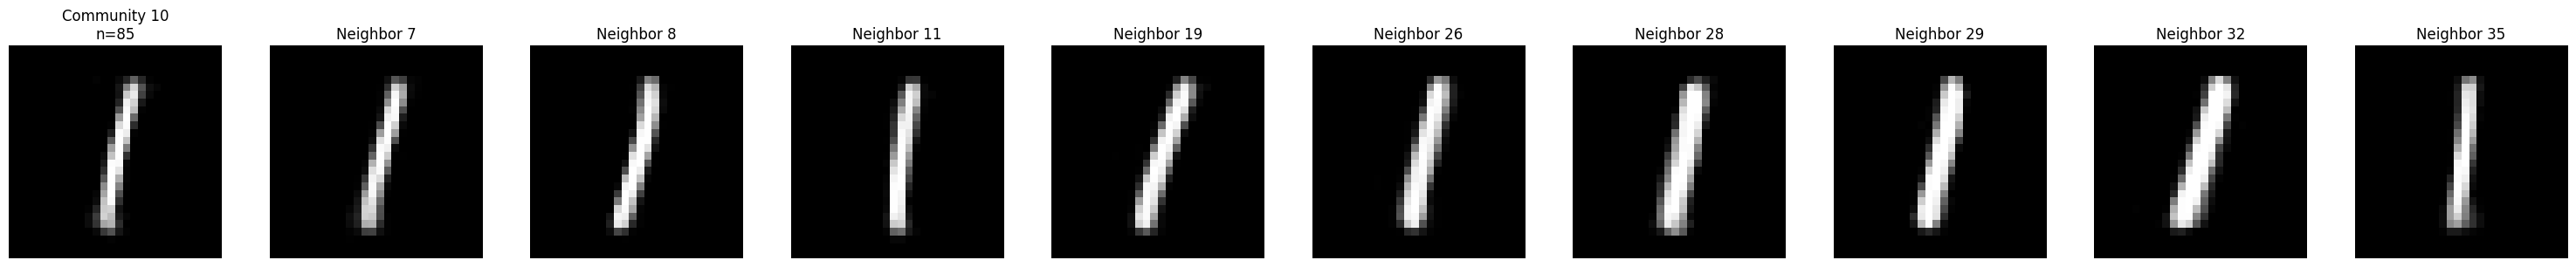

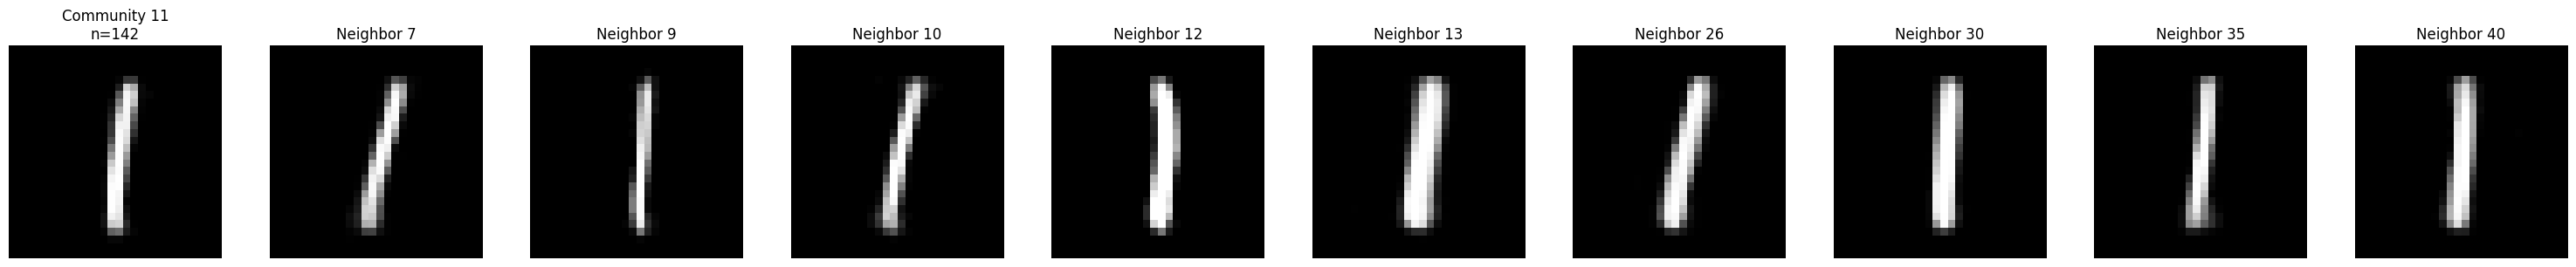

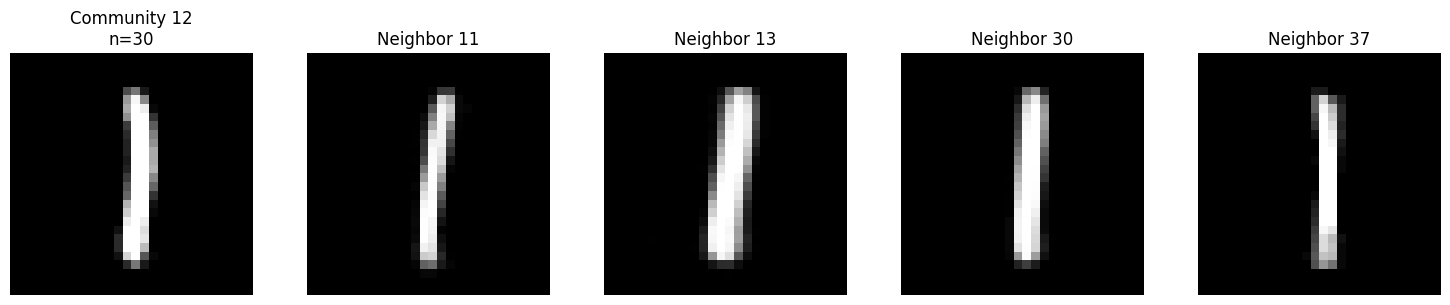

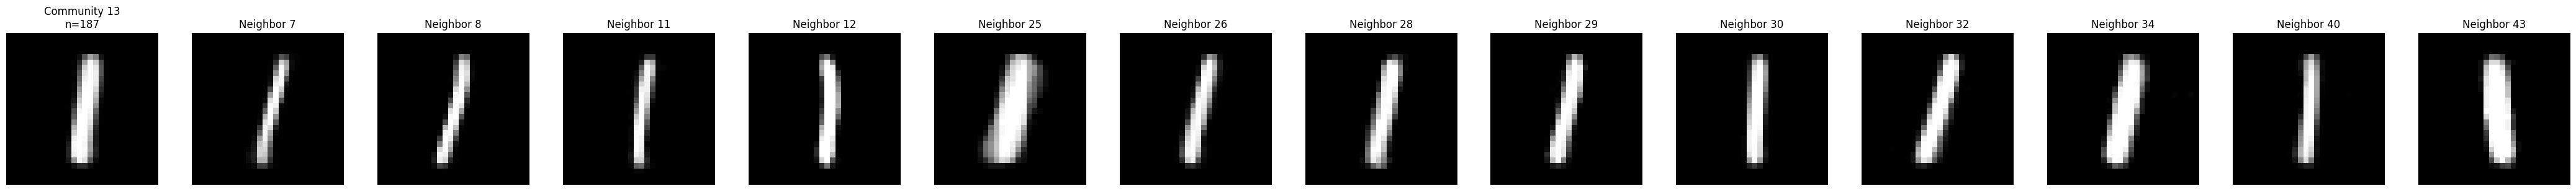

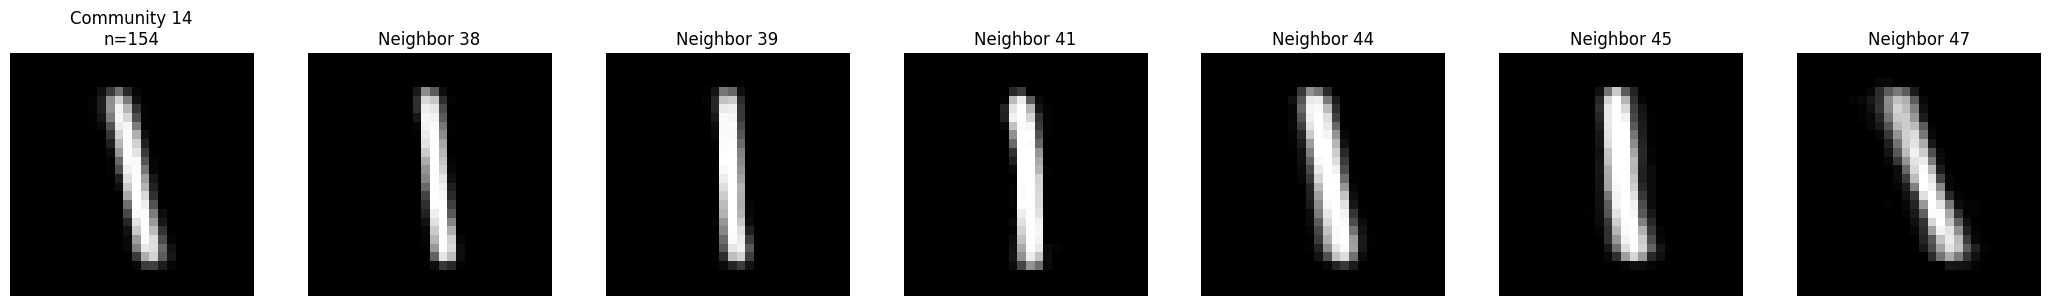

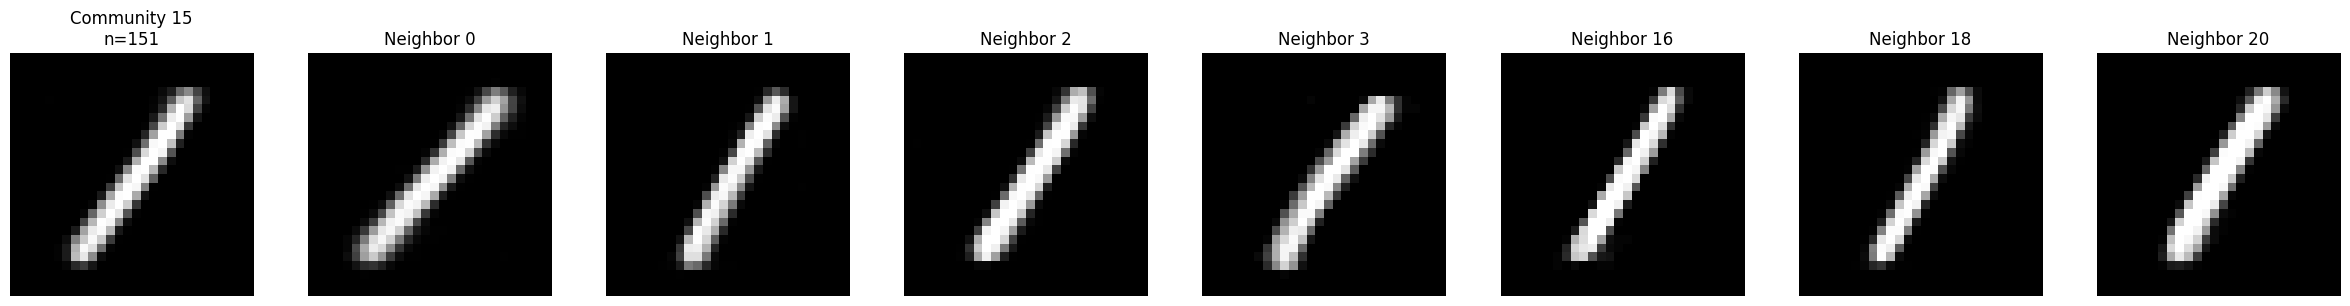

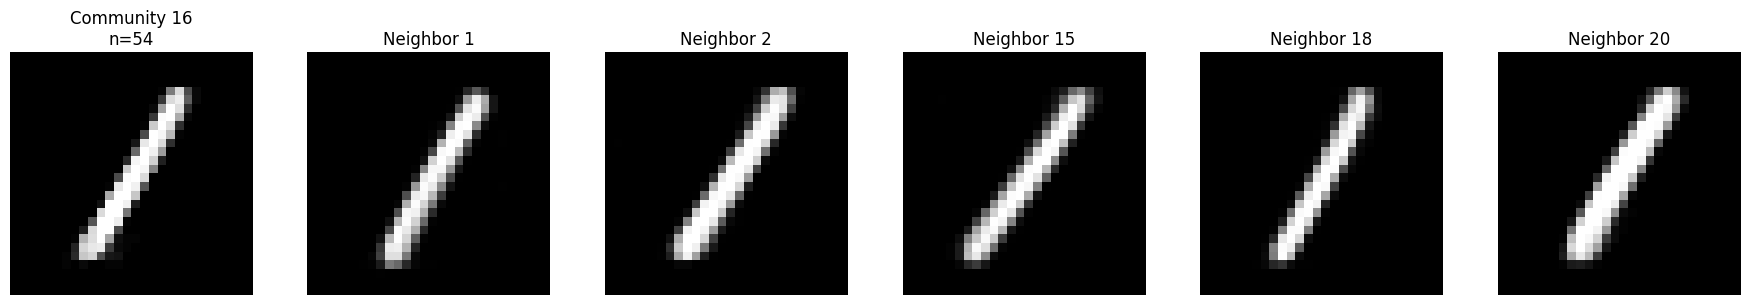

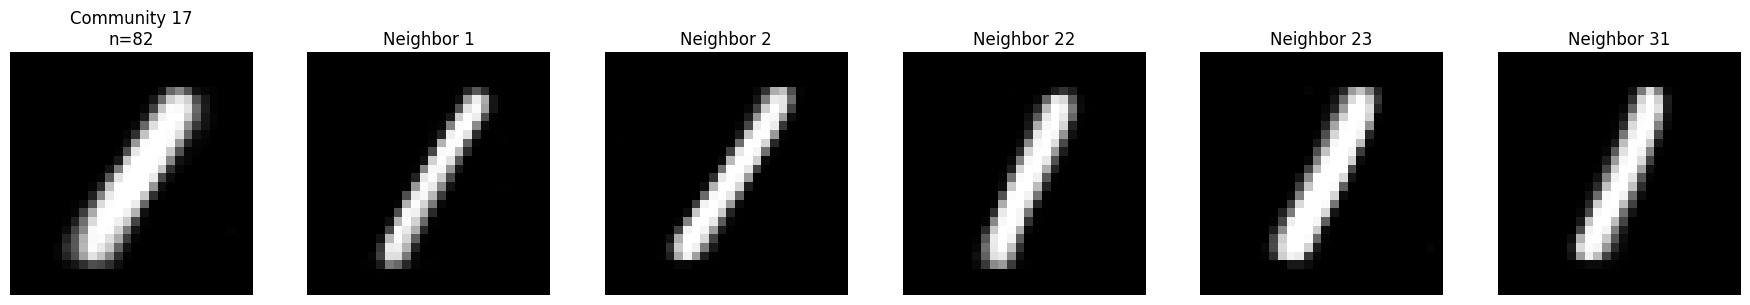

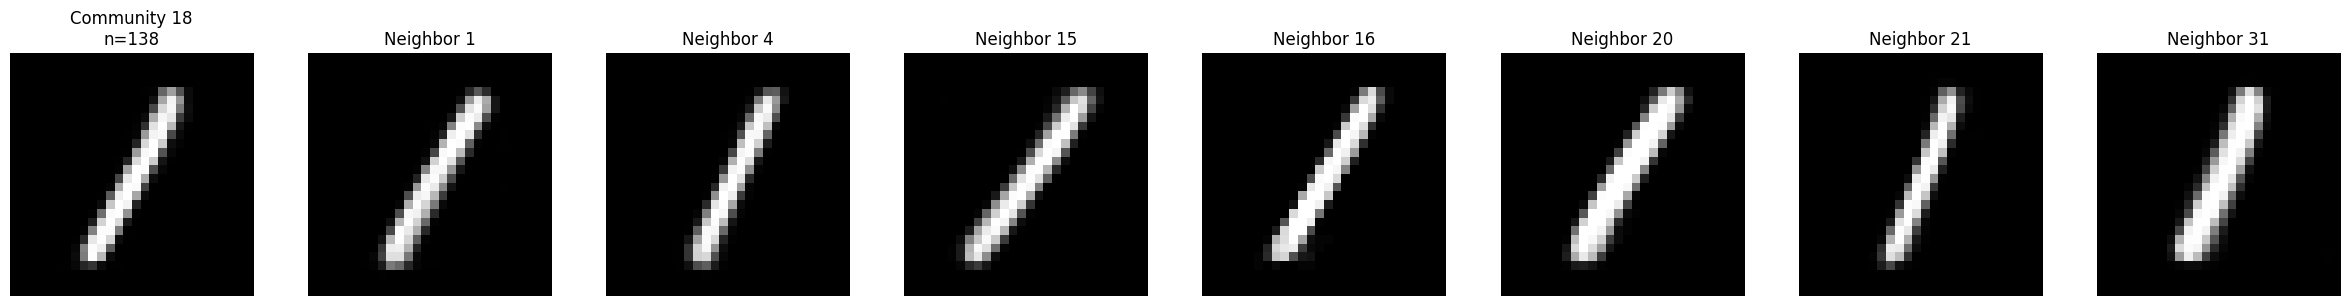

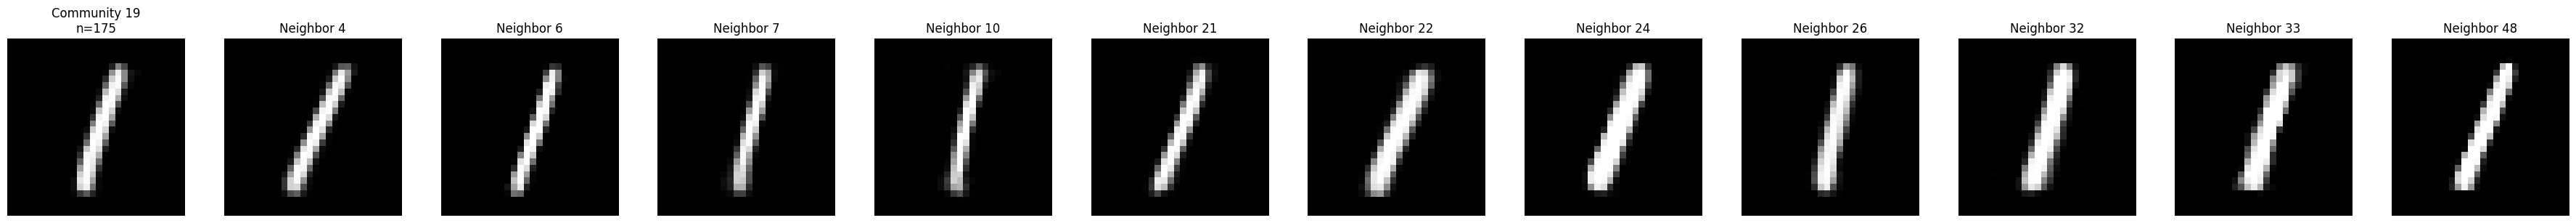

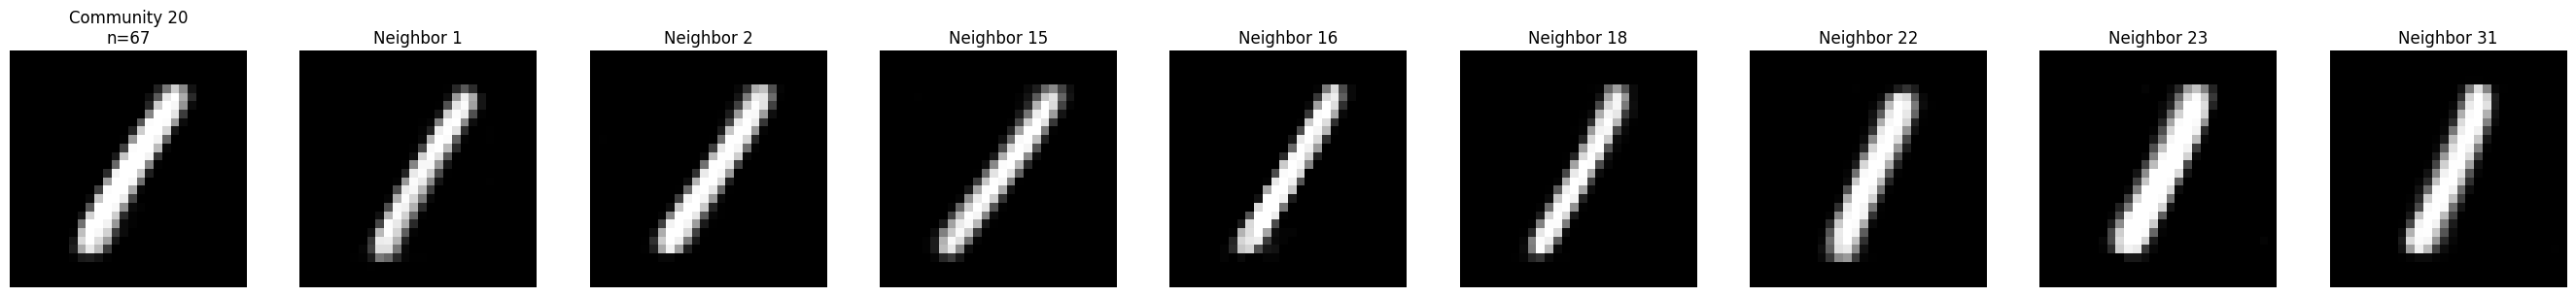

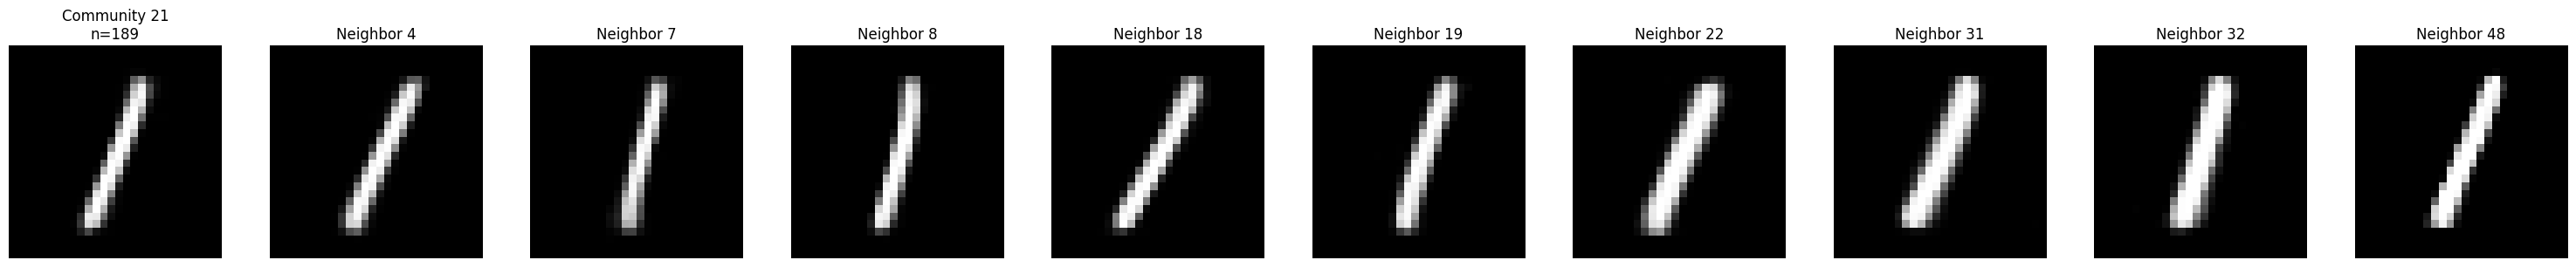

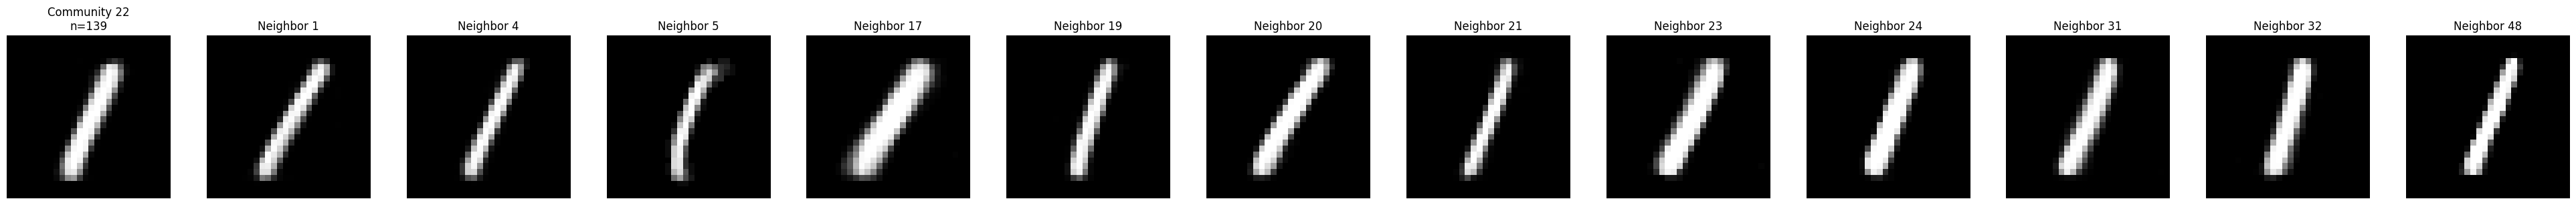

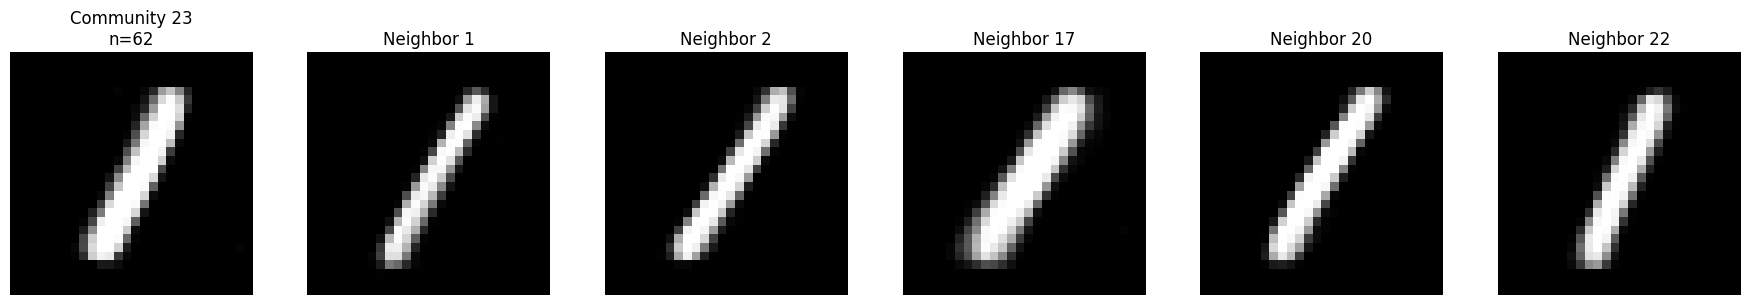

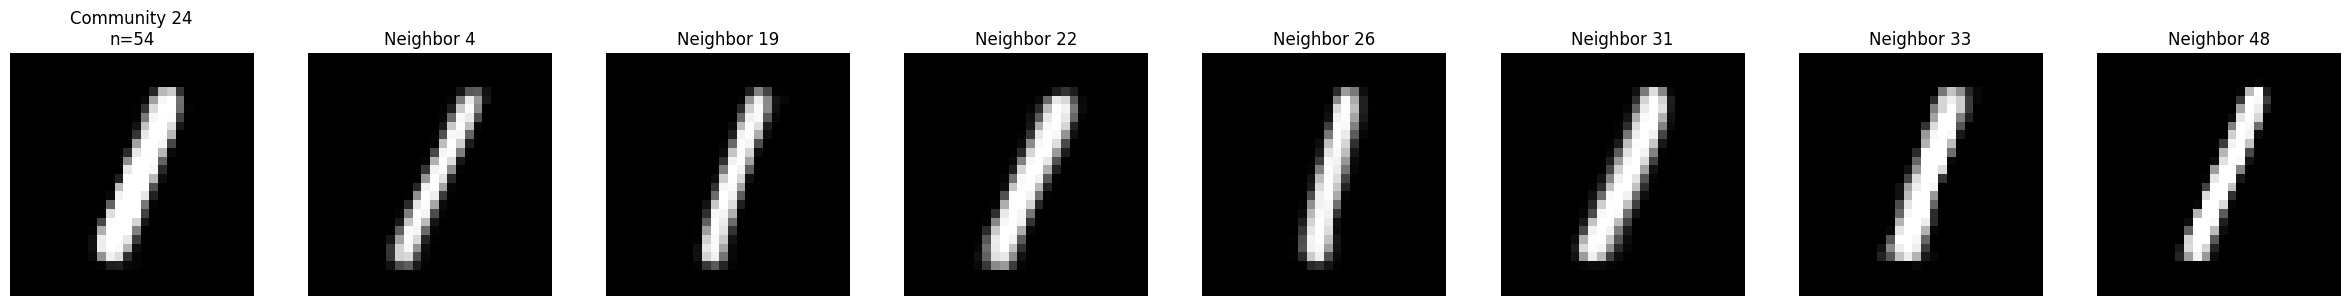

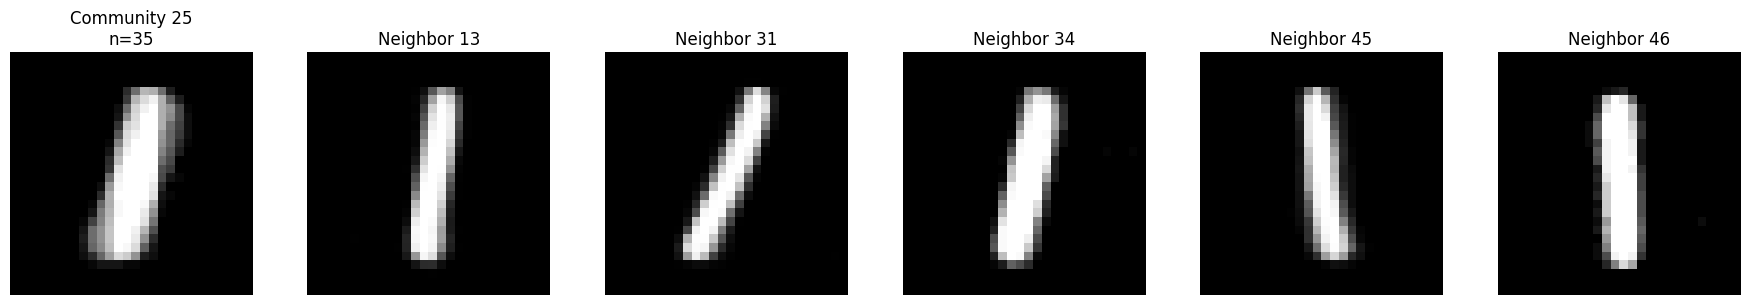

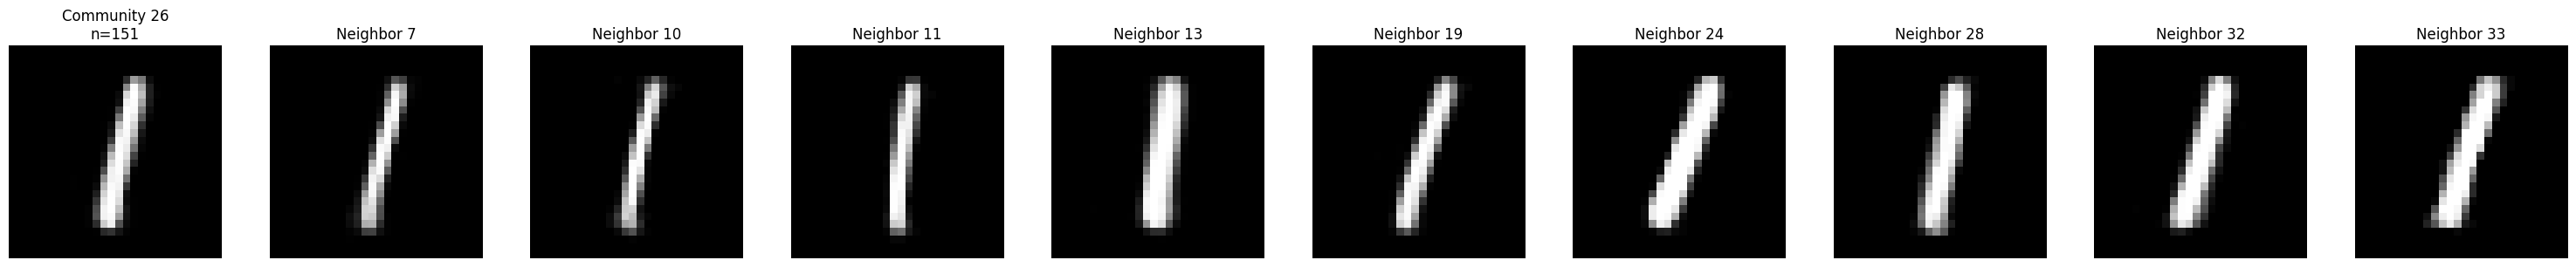

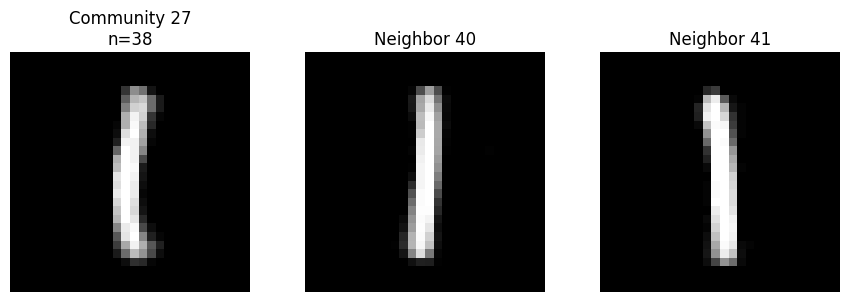

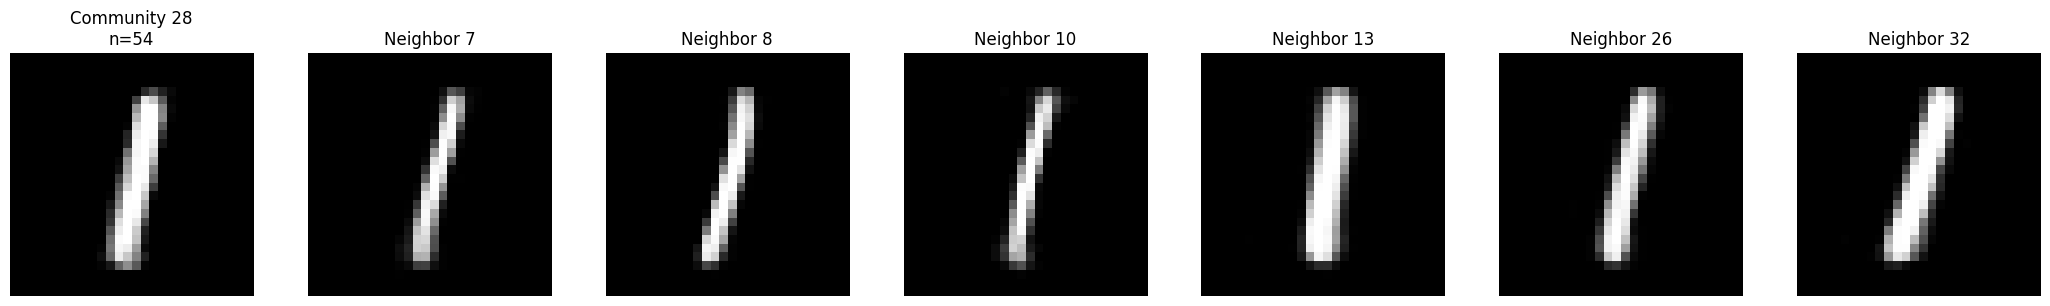

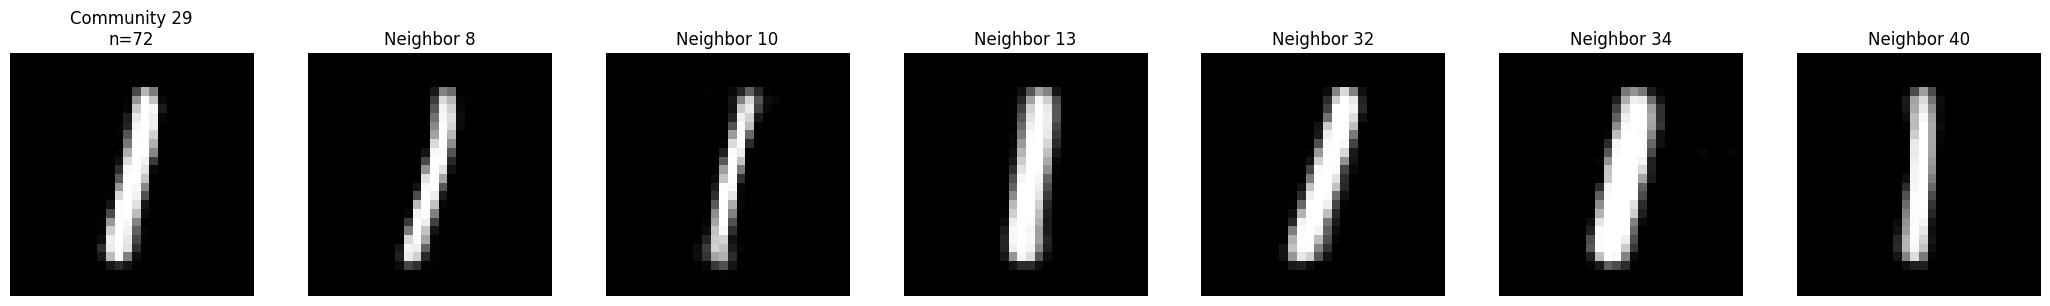

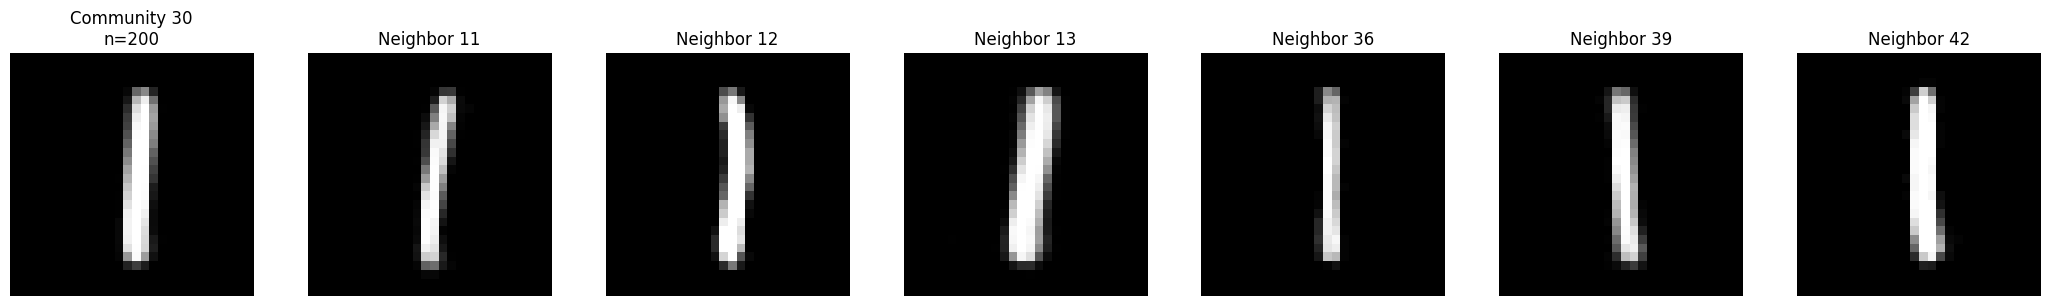

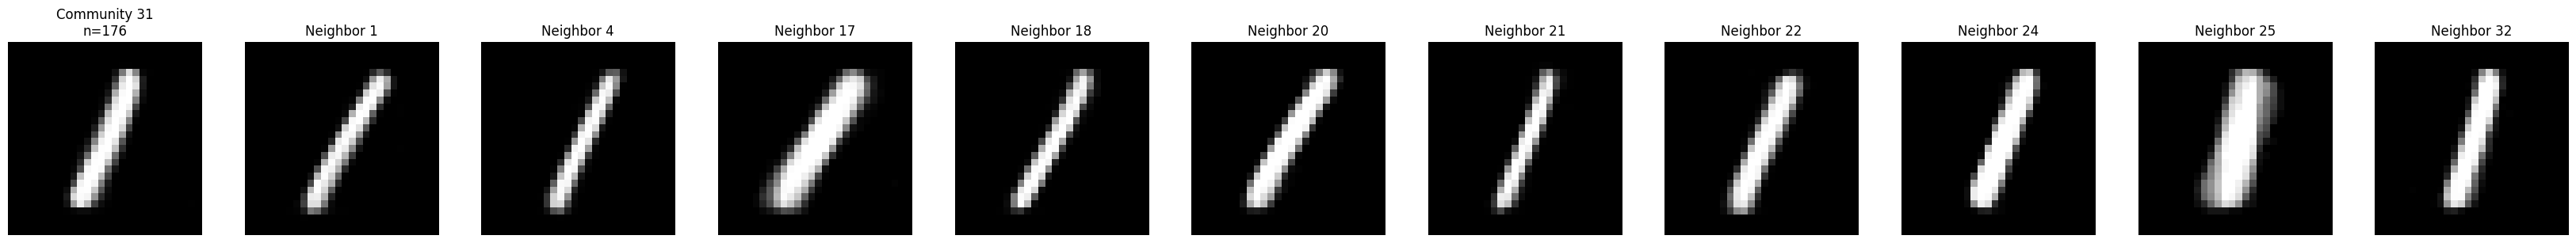

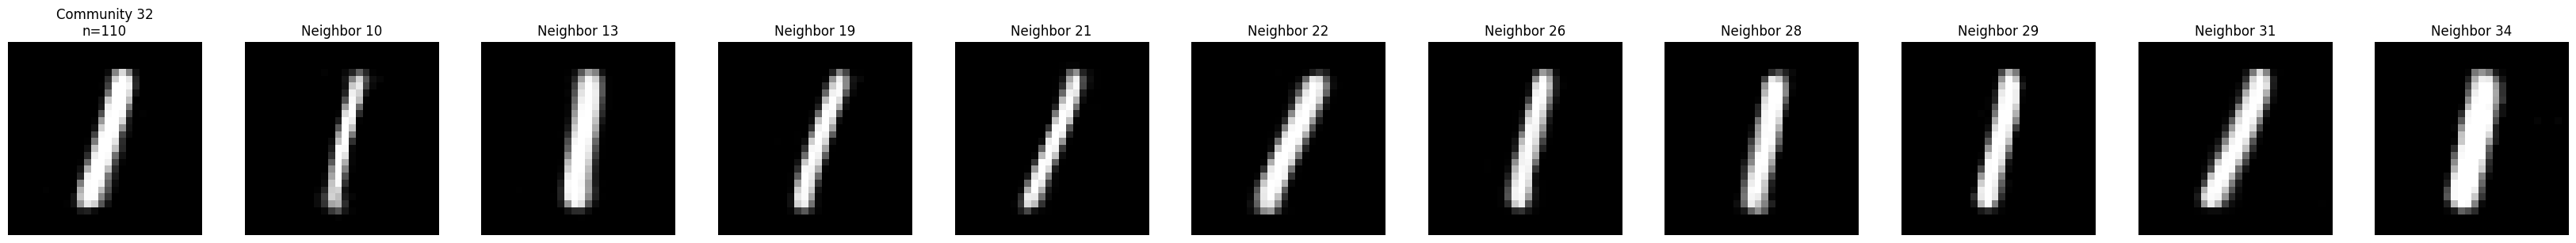

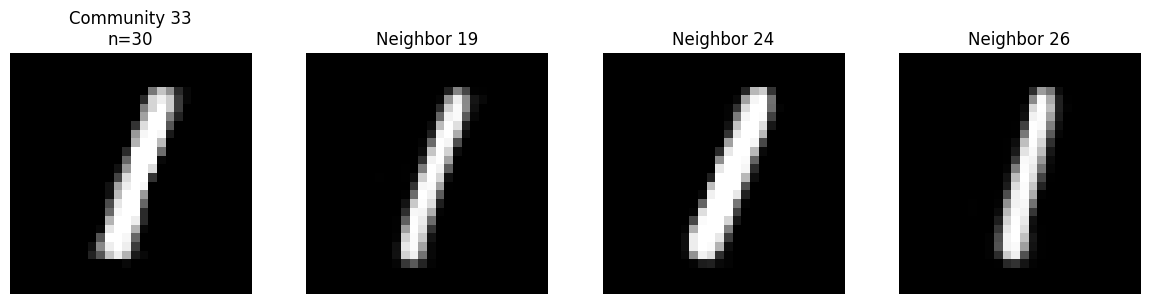

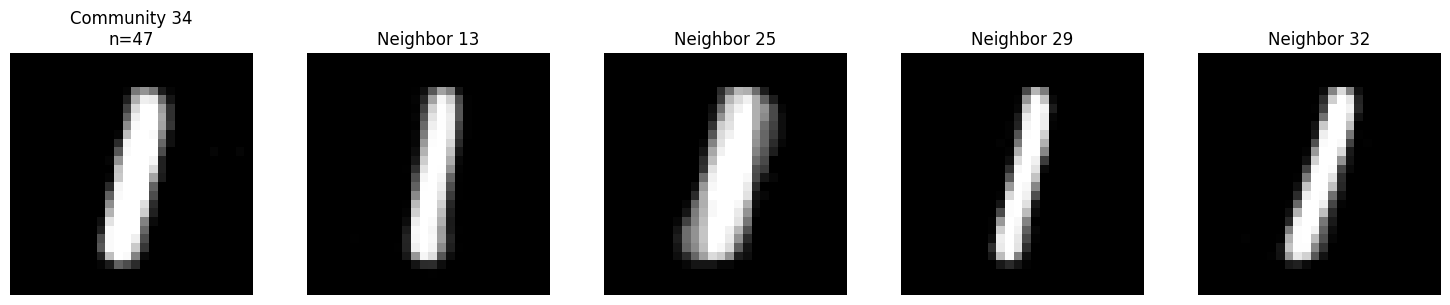

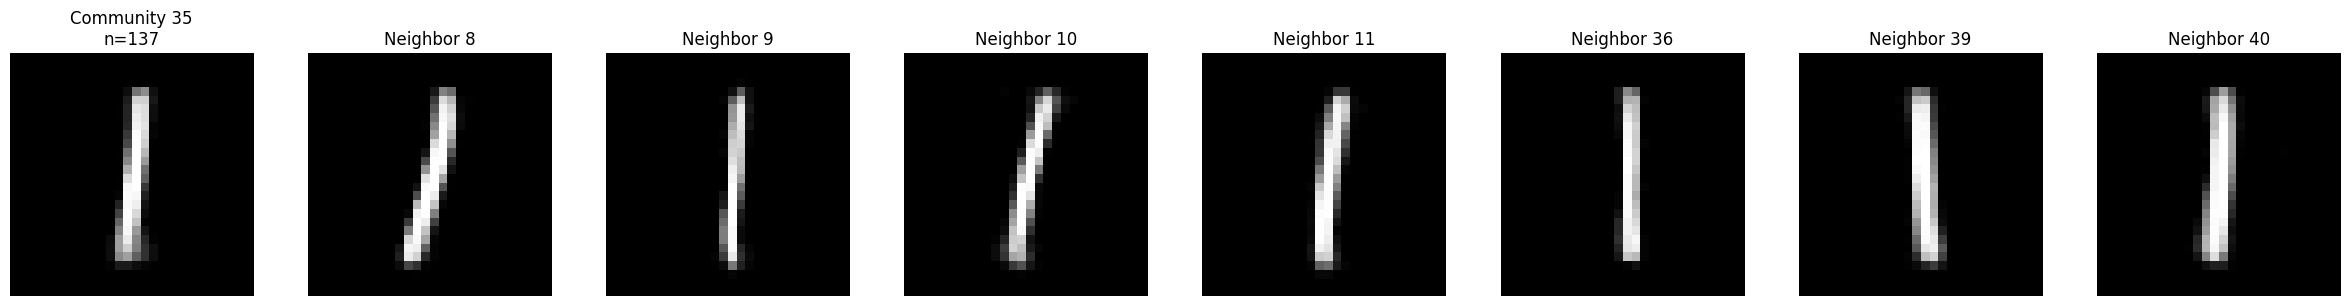

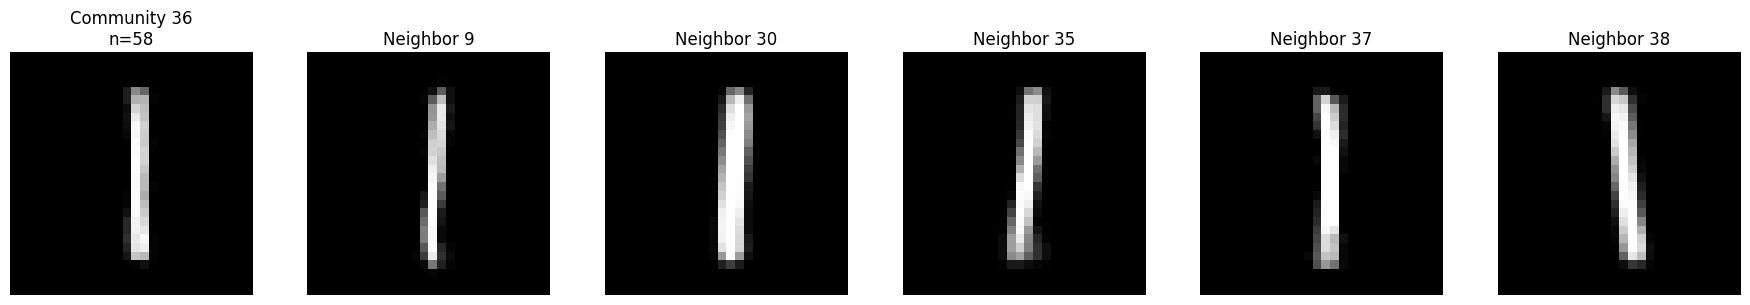

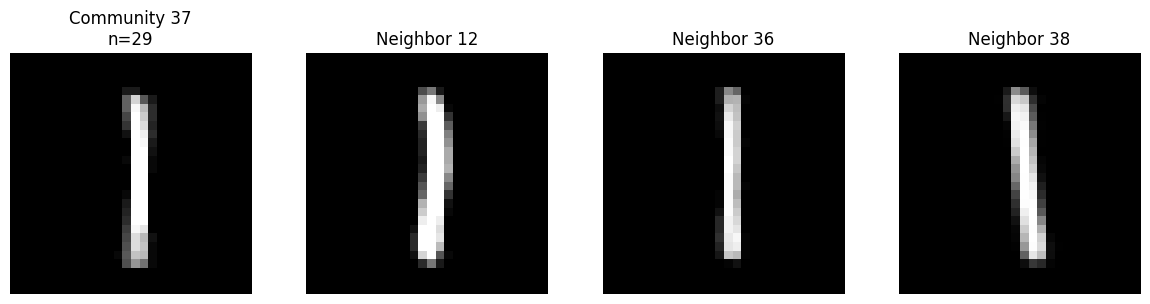

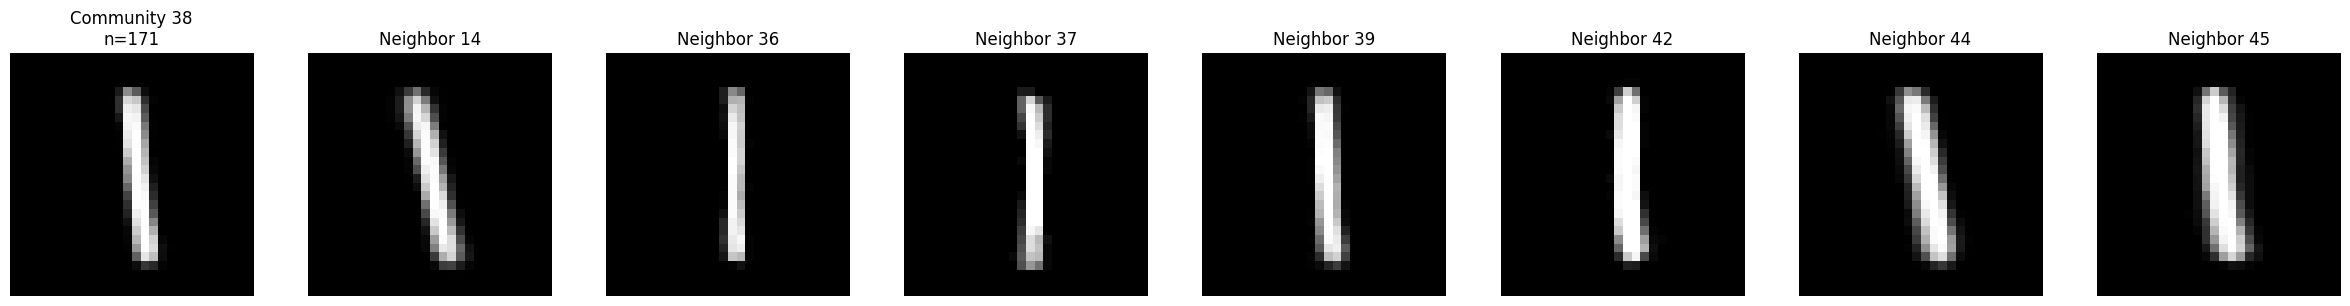

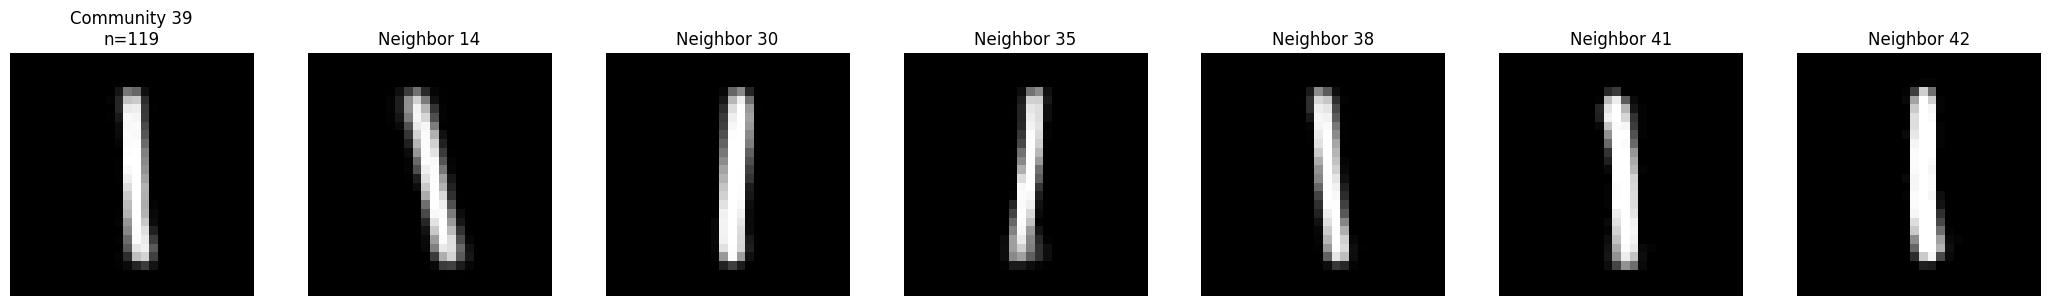

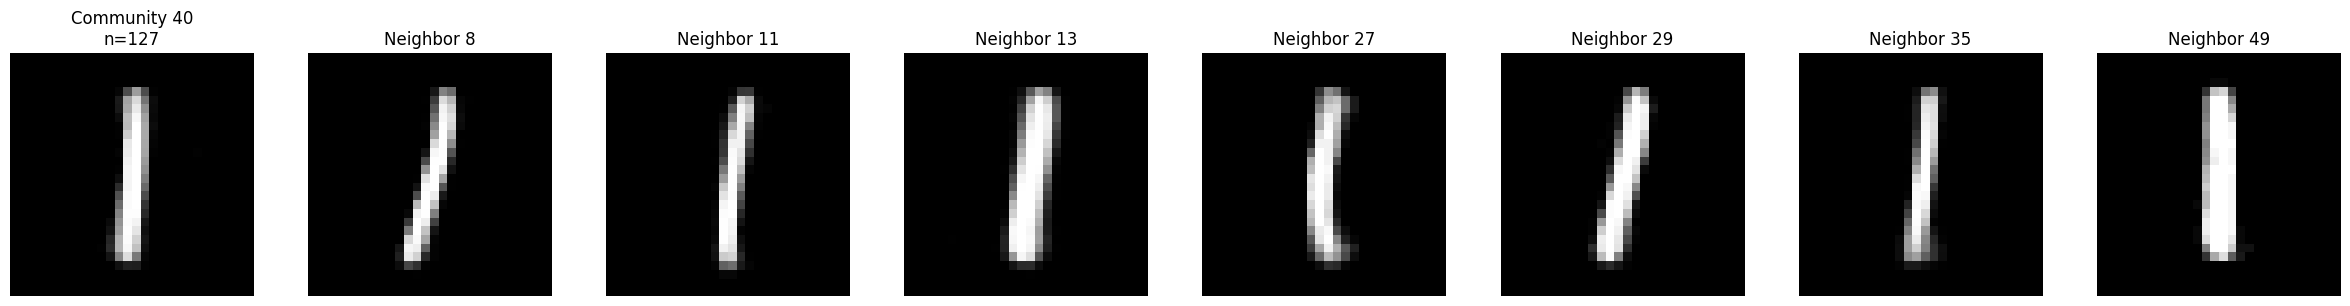

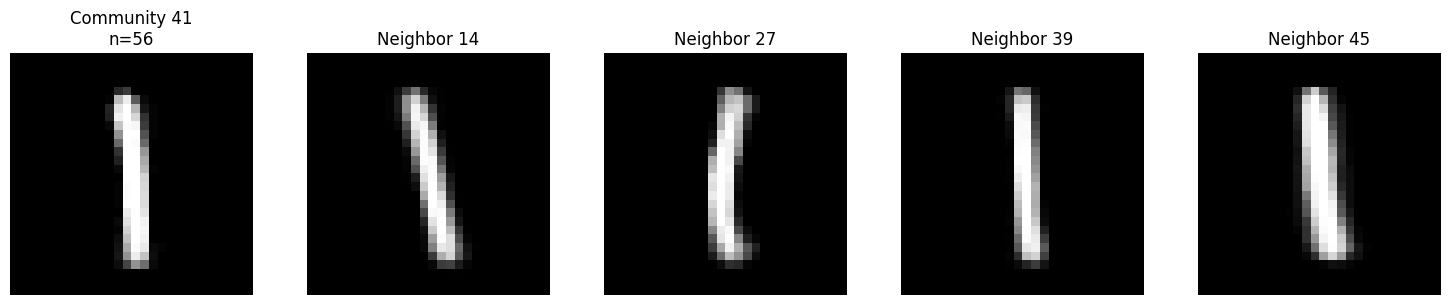

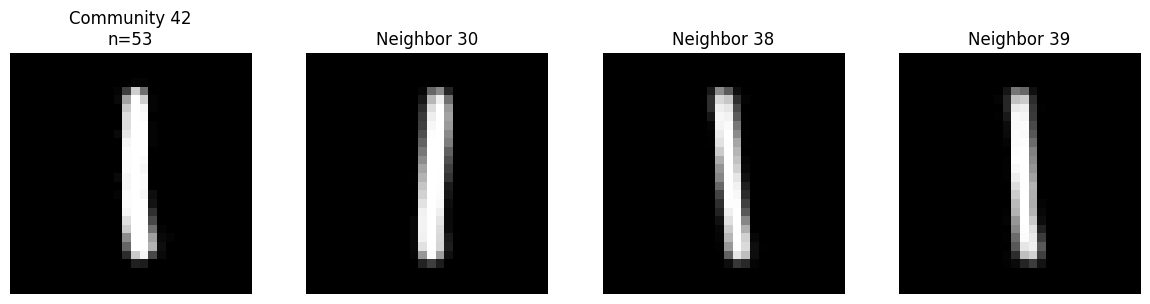

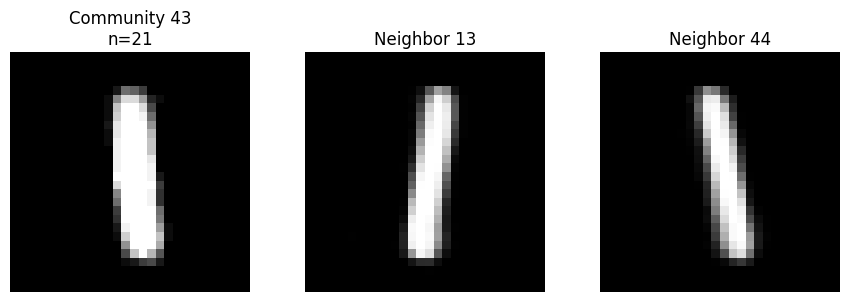

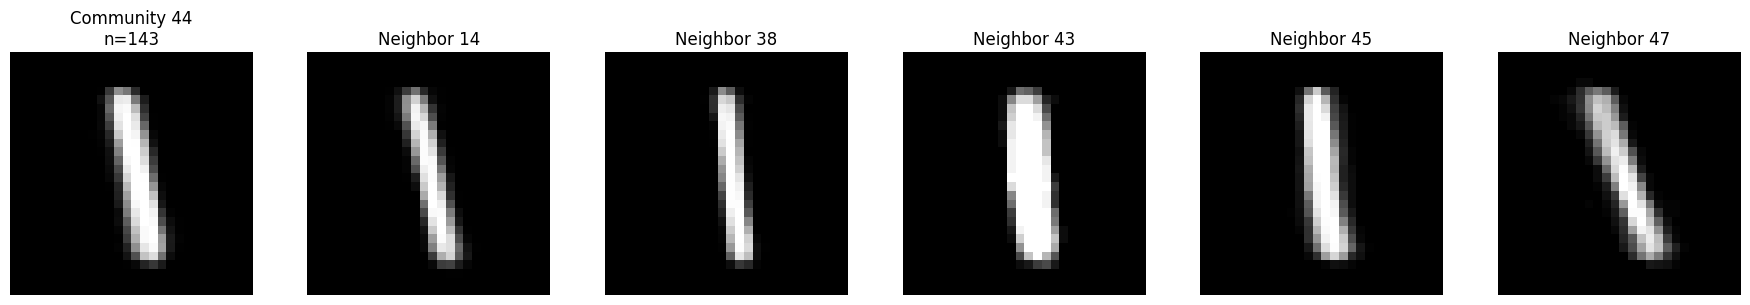

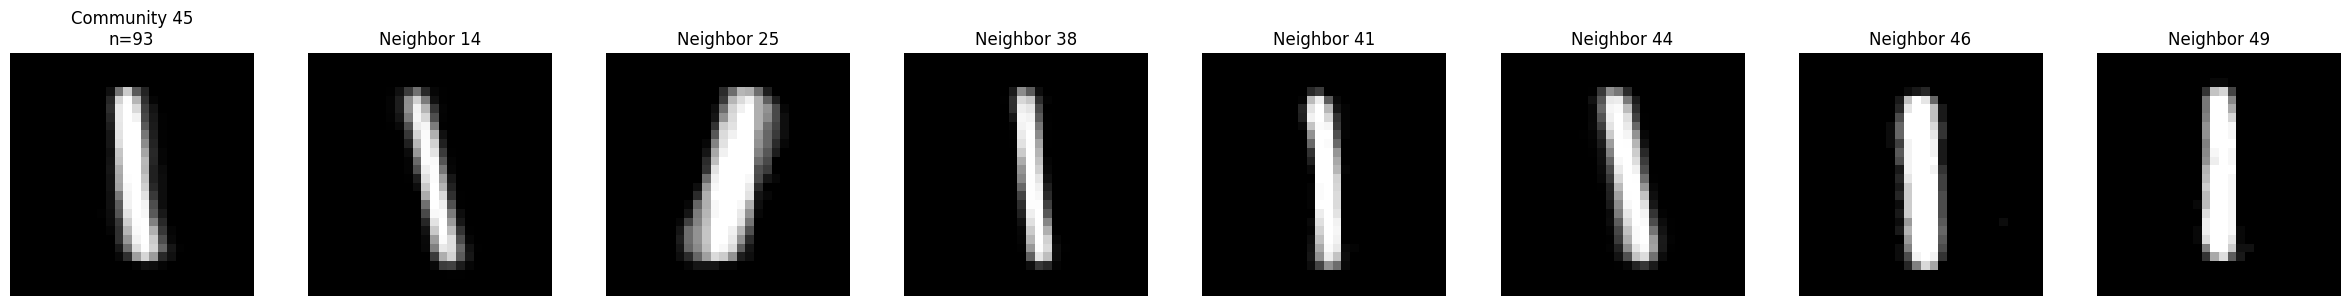

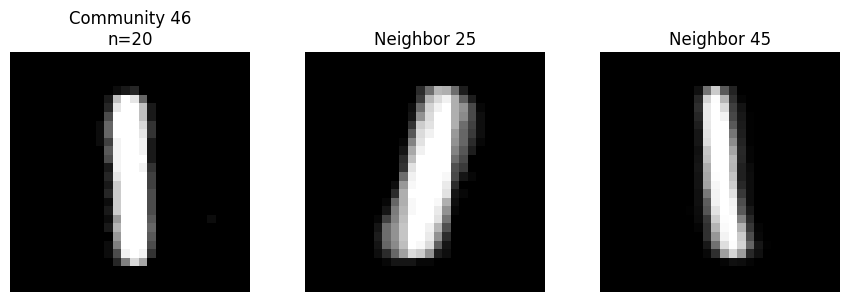

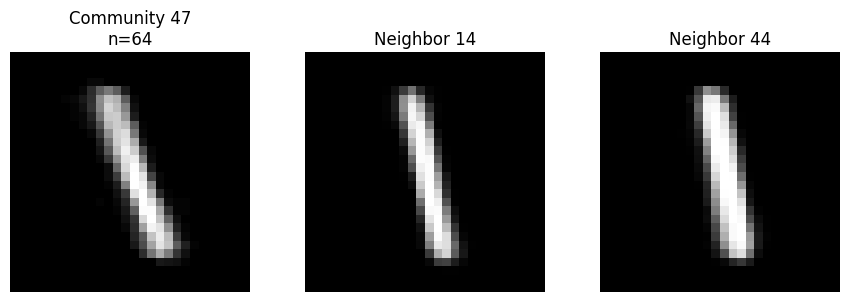

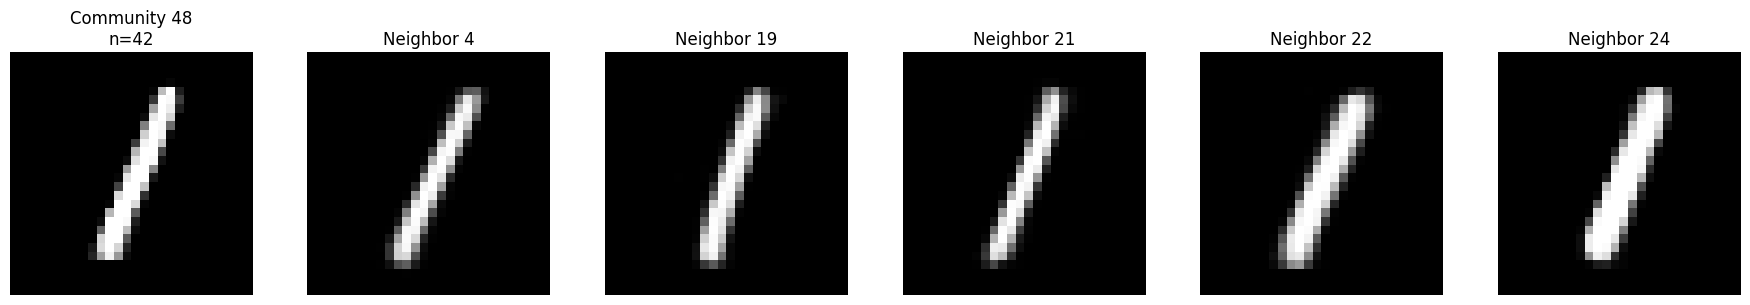

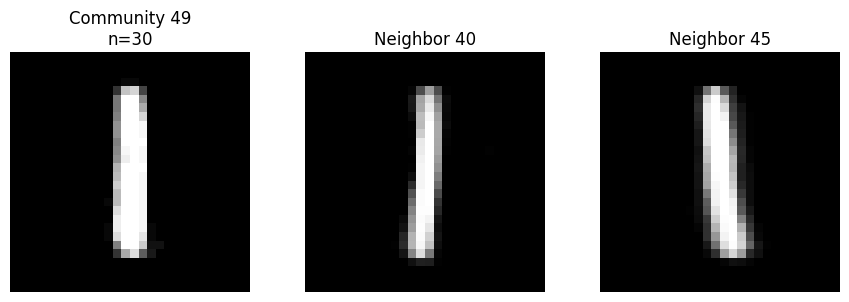

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# For each community, plot its average image followed by the averages of its neighboring communities.
# community_neighbors is assumed to be defined as:
# community_neighbors = { community_id: [neighbor_id, ...], ... }
# num_communities = len(communities)

for i, community in enumerate(communities):
    # Get neighbor communities for community i.
    neighbors = community_neighbors.get(i, [])
    num_subplots = 1 + len(neighbors)  # one for the current community + one for each neighbor

    # Create subplots for this row.
    fig, axs = plt.subplots(1, num_subplots, figsize=(3 * num_subplots, 3))
    if num_subplots == 1:
        axs = [axs]  # ensure list if only one subplot

    # --- Plot the current community's average image ---
    # Map indices from g_largest to global indices:
    global_indices = [largest_component[v] for v in community]
    # Extract vectors for this community.
    community_vectors = unique_vectors[global_indices, :]
    # Compute the average vector. (Using torch.mean; if unique_vectors is a numpy array use np.mean.)
    avg_vector = torch.mean(community_vectors, axis=0)
    # Reshape to 28x28 image.
    avg_image = avg_vector.reshape(28, 28)

    # Plot the current community's average image.
    axs[0].imshow(avg_image, cmap='gray')
    axs[0].set_title(f"Community {i}\nn={len(community)}")
    axs[0].axis("off")

    # --- Plot each neighbor community's average image ---
    for j, nb in enumerate(neighbors):
        # Get the neighbor community (which is a list of vertex indices relative to g_largest).
        nb_community = communities[nb]
        # Map indices from g_largest to global indices for the neighbor.
        nb_global_indices = [largest_component[v] for v in nb_community]
        # Extract the vectors and compute the average image.
        nb_vectors = unique_vectors[nb_global_indices, :]
        nb_avg_vector = torch.mean(nb_vectors, axis=0)
        nb_avg_image = nb_avg_vector.reshape(28, 28)

        axs[j + 1].imshow(nb_avg_image, cmap='gray')
        axs[j + 1].set_title(f"Neighbor {nb}")
        axs[j + 1].axis("off")

    plt.tight_layout()
    plt.show()
